# Código computacional para simulação e processamento dos dados do sensor SPR SPREETA 

Importação das bibliotecas necessárias:

In [107]:
from scipy.integrate import *
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d 
from scipy import optimize
from random import gauss

from numpy import *
from numpy.polynomial import Polynomial
import Reflectivity as ref
import Setting_Layers as sl
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import time

Importação de arquivos dos experimentos com a curva SPR da água e curvas de refêrencia 

In [ ]:
dados = pd.read_csv("experimento_H2O.csv", encoding='latin1')   
dados2 = pd.read_csv("signal reference.csv", encoding='latin1')

pixel = dados['pixel']
signal_ref_AR = dados2['Reference']

signal = dados[' signal']

Conversão de pixel para angulo de incidência (Equação 24 do relatório, baseada no trabalho de SOUSA *et. al* (2013) )

In [ ]:
theta_i = []

for i in pixel:
    theta_i.append((3.1522 * 1E-5 * i**2) - (0.0661 * i) + 73.4533)

Definição da função que calcula o índice de refração do ouro, baseada na interpolação dos dados de Johnson e Christy (1972) coletados a partir do site *refractive index.info*

In [ ]:
# Definição de função para calcular o indice de refração
def set_index_3(lambda_i):
    X = [0.1879, 0.1916, 0.1953, 0.1993, 0.2033, 0.2073, 0.2119, 0.2164, 0.2214, 0.2262, 0.2313, 0.2371,
                 0.2426, 0.2490, 0.2551, 0.2616, 0.2689, 0.2761, 0.2844, 0.2924, 0.3009, 0.3107, 0.3204, 0.3315,
                 0.3425, 0.3542, 0.3679, 0.3815, 0.3974, 0.4133, 0.4305, 0.4509, 0.4714, 0.4959, 0.5209, 0.5486,
                 0.5821, 0.6168, 0.6595, 0.7045, 0.756, 0.8211, 0.892, 0.984, 1.088, 1.216, 1.393, 1.61, 1.937, 3.5]

    n = [1.28, 1.32, 1.34, 1.33, 1.33, 1.30, 1.30, 1.30, 1.30, 1.31, 1.30, 1.32, 1.32,
            1.33, 1.33, 1.35, 1.38, 1.43, 1.47, 1.49, 1.53, 1.53, 1.54,
            1.48, 1.48, 1.50, 1.48, 1.46, 1.47, 1.46, 1.45, 1.38, 1.31, 1.04,
            0.62, 0.43, 0.29, 0.21, 0.14, 0.13, 0.14, 0.16, 0.17, 0.22, 0.27, 0.35, 0.43, 0.56, 0.92, 1.8]

    k_index = [1.188, 1.203, 1.226, 1.251, 1.277, 1.304, 1.35, 1.387, 1.427, 1.46, 1.497, 1.536, 1.577,
                1.631, 1.688, 1.749, 1.803, 1.847, 1.869, 1.878, 1.889, 1.893, 1.898, 1.883, 1.871, 1.866, 1.895,
                1.933, 1.952, 1.958, 1.948, 1.914, 1.849, 1.833, 2.081, 2.455, 2.863, 3.272, 3.697, 4.103, 4.542,
                5.083, 5.663, 6.35, 7.15, 8.145, 9.519, 11.21, 13.78, 25]
    
    Lambda_i = lambda_i*1E-9 * 1e6 
    n_interp = interp(Lambda_i, X, n)
    k_interp = interp(Lambda_i, X, k_index)
    
    n0 = round(n_interp, 5)  # Rounded to five decimal places
    k0 = round(k_interp, 5)  # Rounded to five decimal places

    # Returns the complex refractive index for each material
    return complex(n0, k0)
    
idx = lambda w_i: set_index_3(w_i)

## Modelagem da fonte de luz

Leitura do arquivo "Default Dataset.csv", que contêm os pontos do gráfico da intensidade da luz do LED, coletados a partir do site *Webplotdigitizer*, e geração da curva aproximada por *spline* cubica sendo armazenada na variável *'sp'* - $\rho(\lambda)$

In [ ]:
dset1 = pd.read_csv("Default Dataset.csv", encoding='latin1')
dset1.dropna()

energy = dset1['E_2']/100000
lambda_i = dset1['l'] + dset1['L_2']/100000

sp = interp1d(lambda_i, energy, kind='cubic')


Plotagem da curva gerada pelo *spline* - $\rho(\lambda)$ 

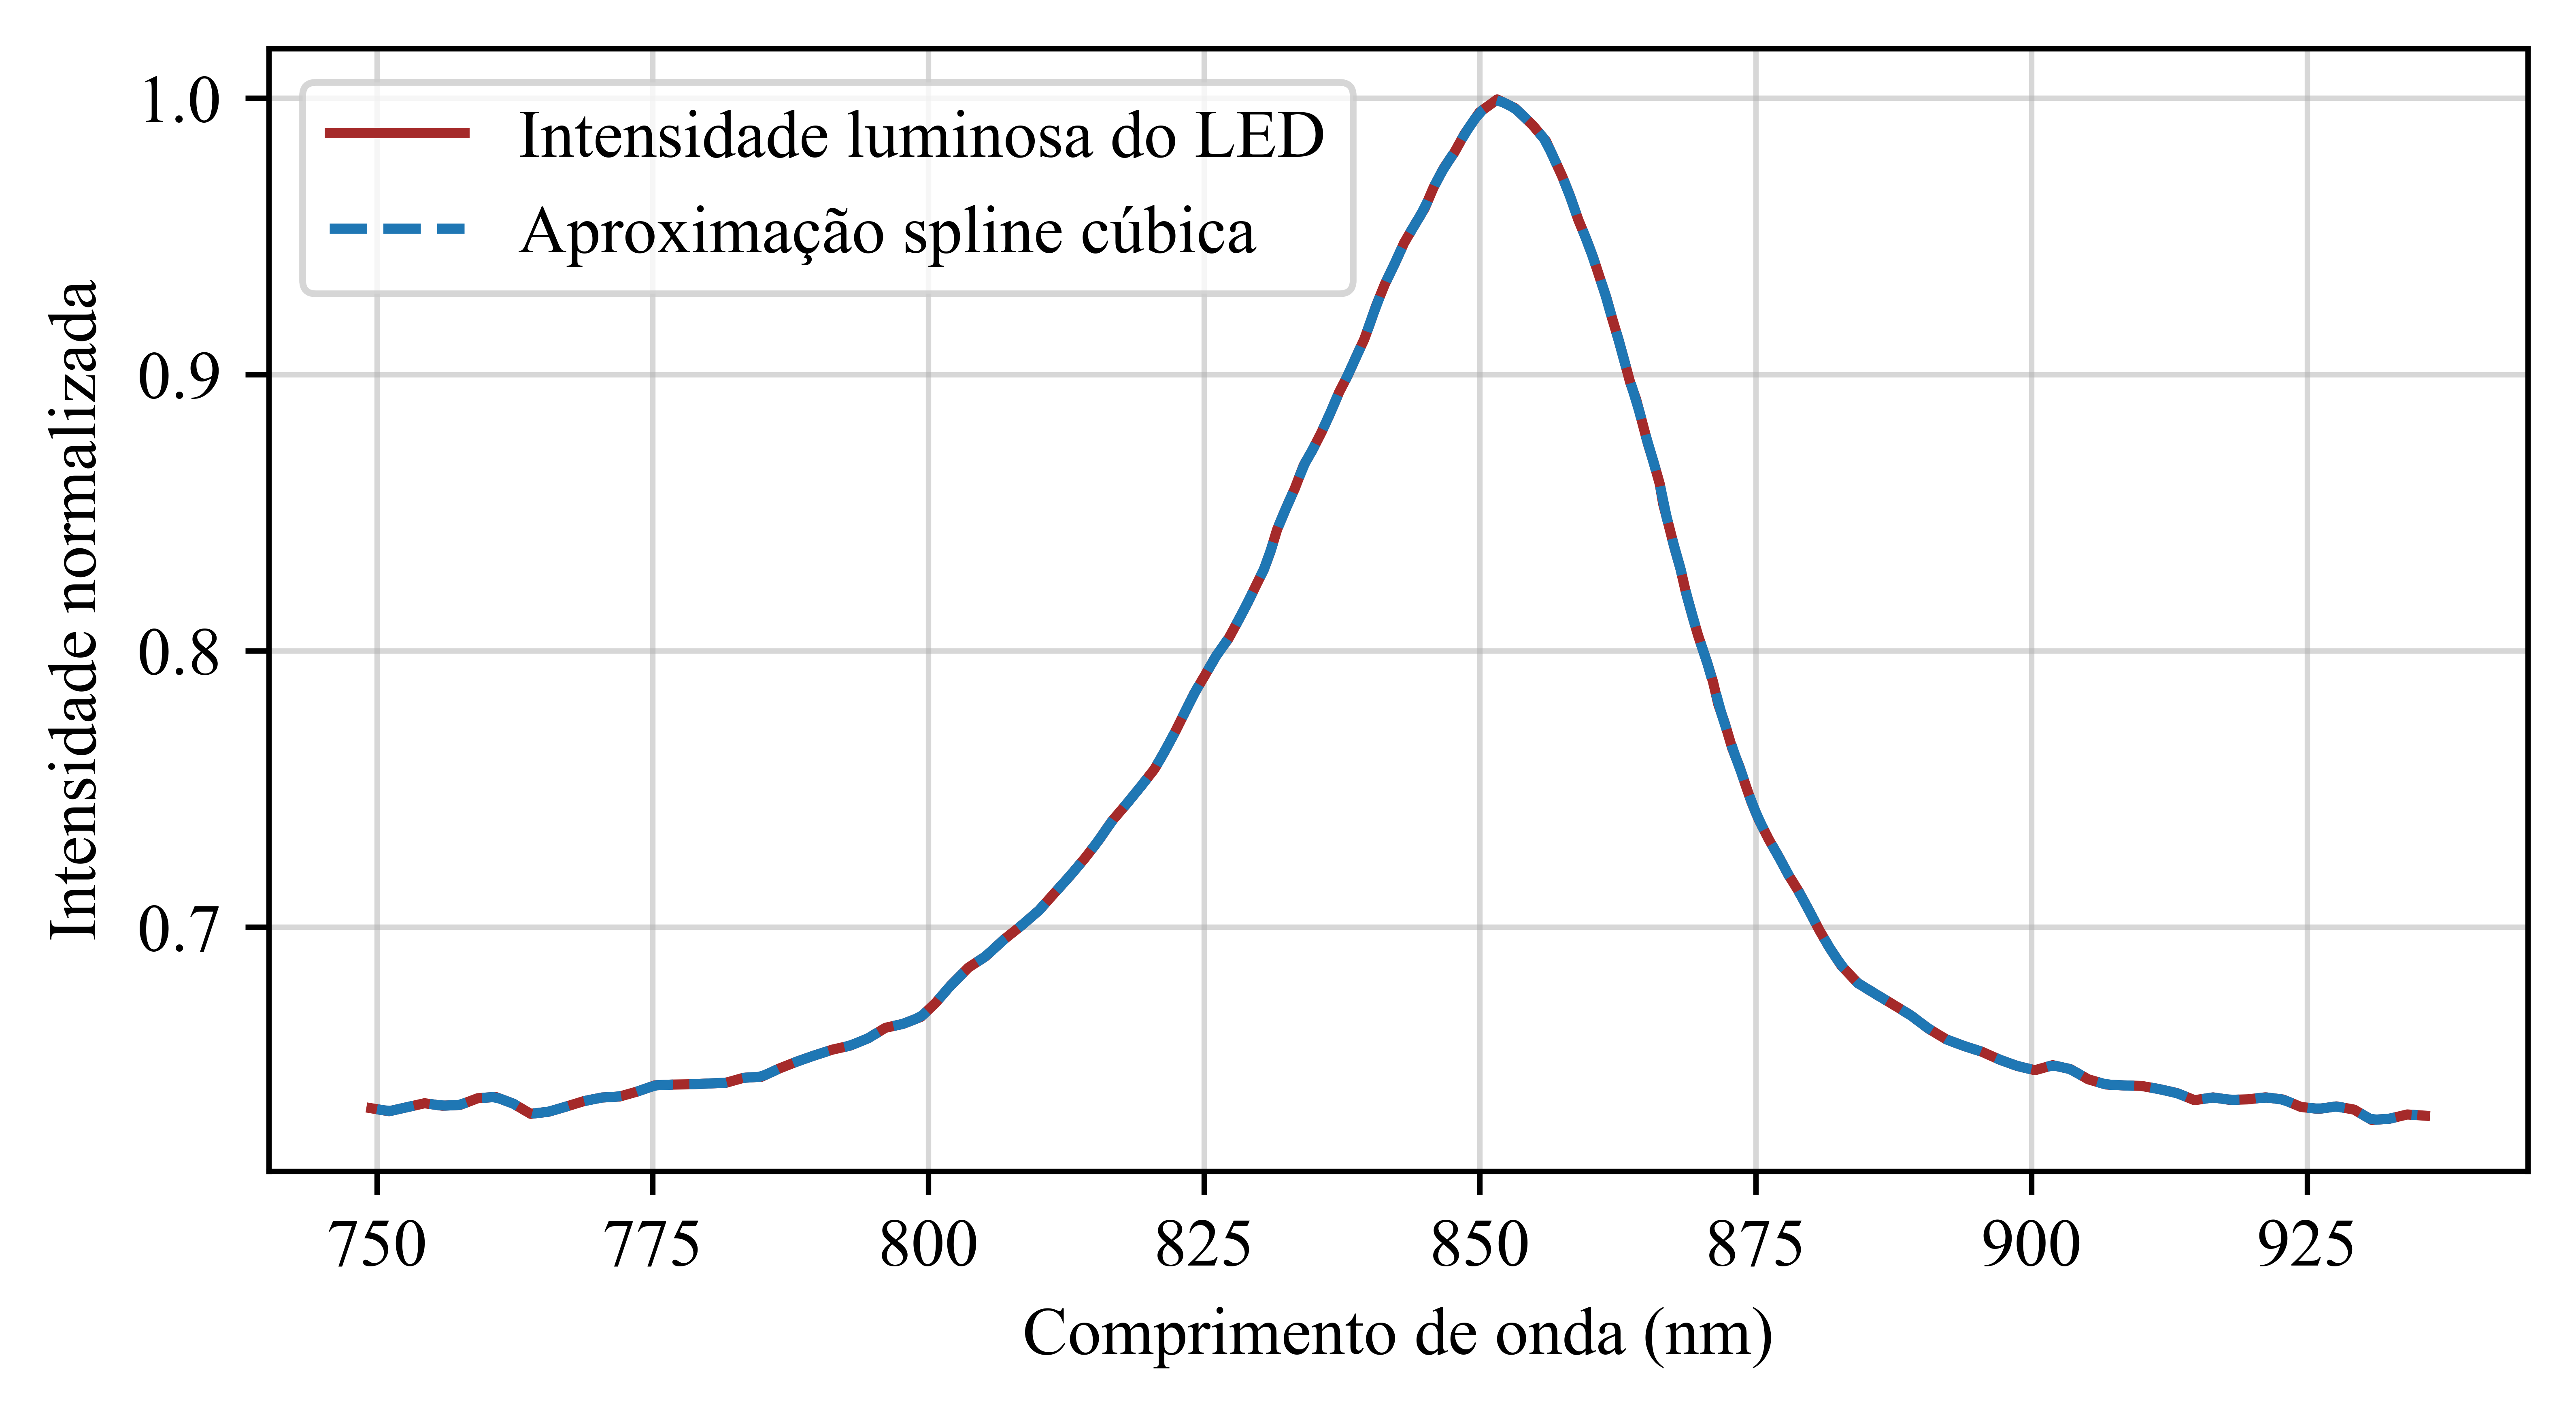

In [54]:
mpl.rc('font', family = 'Times New Roman')

x = list(linspace(750, 935, 300))
y2 = []
for i in x:
    y2.append(sp(i))

fig, ax = plt.subplots(dpi = 1200, figsize=(6,3))
plt.plot(lambda_i, energy, '-',color ='brown', label = "Intensidade luminosa do LED")
plt.plot(x, y2, '--', label = "Aproximação spline cúbica")
plt.grid(True, alpha=0.5)
plt.ylabel('Intensidade normalizada')
plt.xlabel('Comprimento de onda (nm)')
plt.legend()
plt.show()


## Cálculo para a curva SPR considerando o espalhamento da fonte de luz

Definição da função que ecalcula a refletividade $r(\theta, \lambda)$

In [57]:

r = lambda theta, lambda_i: ref.reflectivity(3, [1, 50*1E-9, 1], [1.4826, set_index_3(lambda_i), 1.330], theta*pi/180, lambda_i*1e-9)
    

Definição da função f($\lambda$,$\theta$) = r($\lambda$, $\theta$) $\cdot$ $\rho$ ($\lambda$) que modela a ponderação do espalhamento do LED em cada comprimento de onda.

In [58]:
def f(w_i, theta):
    return (r(theta, w_i)*sp(w_i))

Definição da integral $\int_{\lambda_I}^{\lambda_F} r(\lambda, \theta) \cdot \rho(\lambda)\,d\lambda$

In [59]:
integrals = [[a, quad(f,  750, 930, args=(a))[0]] for a in theta_i]

C:\Users\Adeilson\AppData\Local\Temp\ipykernel_11780\2053923459.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrals = [[a, quad(f,  750, 930, args=(a))[0]] for a in theta_i]
C:\Users\Adeilson\AppData\Local\Temp\ipykernel_11780\2053923459.py:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrals = [[a, quad(f,  750, 930, args=(a))[0]] for a in theta_i]


Resolução da equação: $R(\theta)$ = $\frac{\int_{\lambda_I}^{\lambda_F} r(\lambda, \theta) \cdot \rho(\lambda)\,d\lambda}{\int_{\lambda_I}^{\lambda_F} \rho(\lambda)\,d\lambda}$


In [85]:
reflectancia= array(integrals).T[1] / quad(sp, 750, 930)[0]

C:\Users\Adeilson\AppData\Local\Temp\ipykernel_11780\2219761703.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  reflectancia= array(integrals).T[1] / quad(sp, 750, 930)[0]


Comparativo entre as curvas com e sem espalhamento do fonte de luz

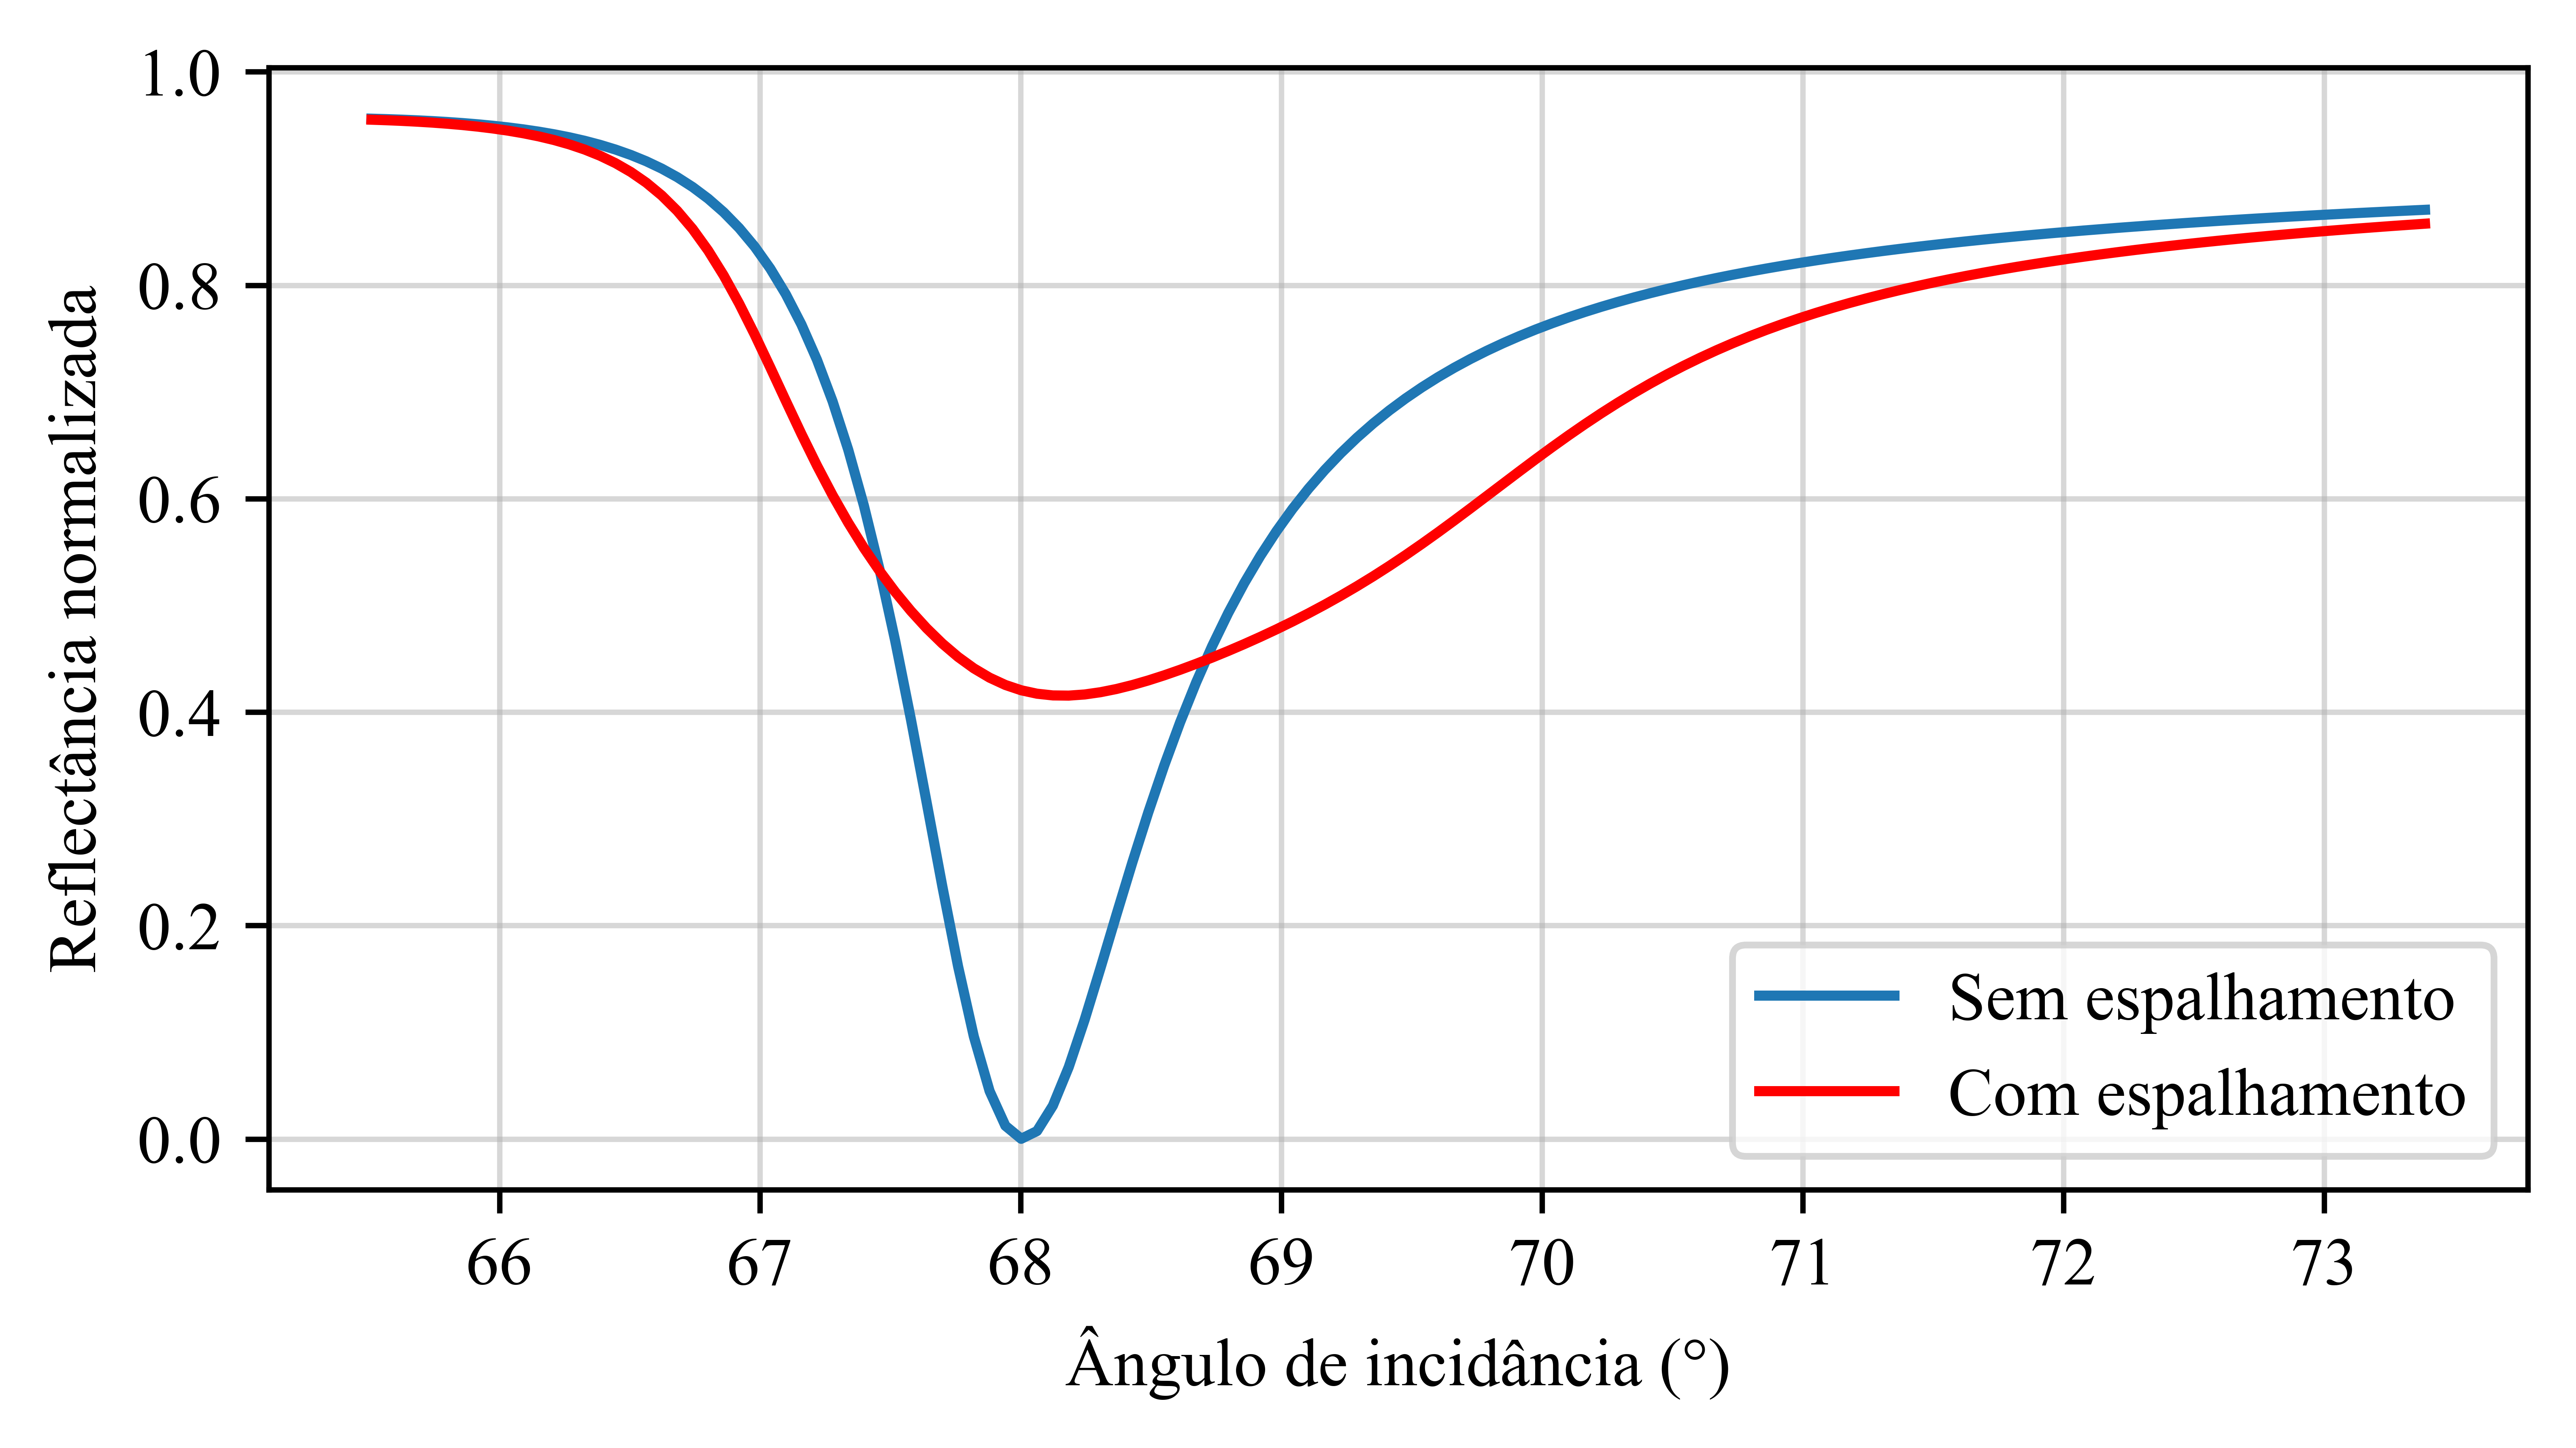

In [86]:
R = [r(t, 850) for t in theta_i]
fig, ax = plt.subplots(dpi = 1200, figsize=(6,3))
ax.plot(theta_i, R, label = 'Sem espalhamento')
ax.plot(theta_i, reflectancia, color='r', label='Com espalhamento')
plt.grid(True, alpha=0.5)
plt.legend()
plt.xlabel("Ângulo de incidância (°)")
plt.ylabel("Reflectância normalizada")
plt.show()

Comparativo entre das curvas com e sem espalhamento com a curva experimental

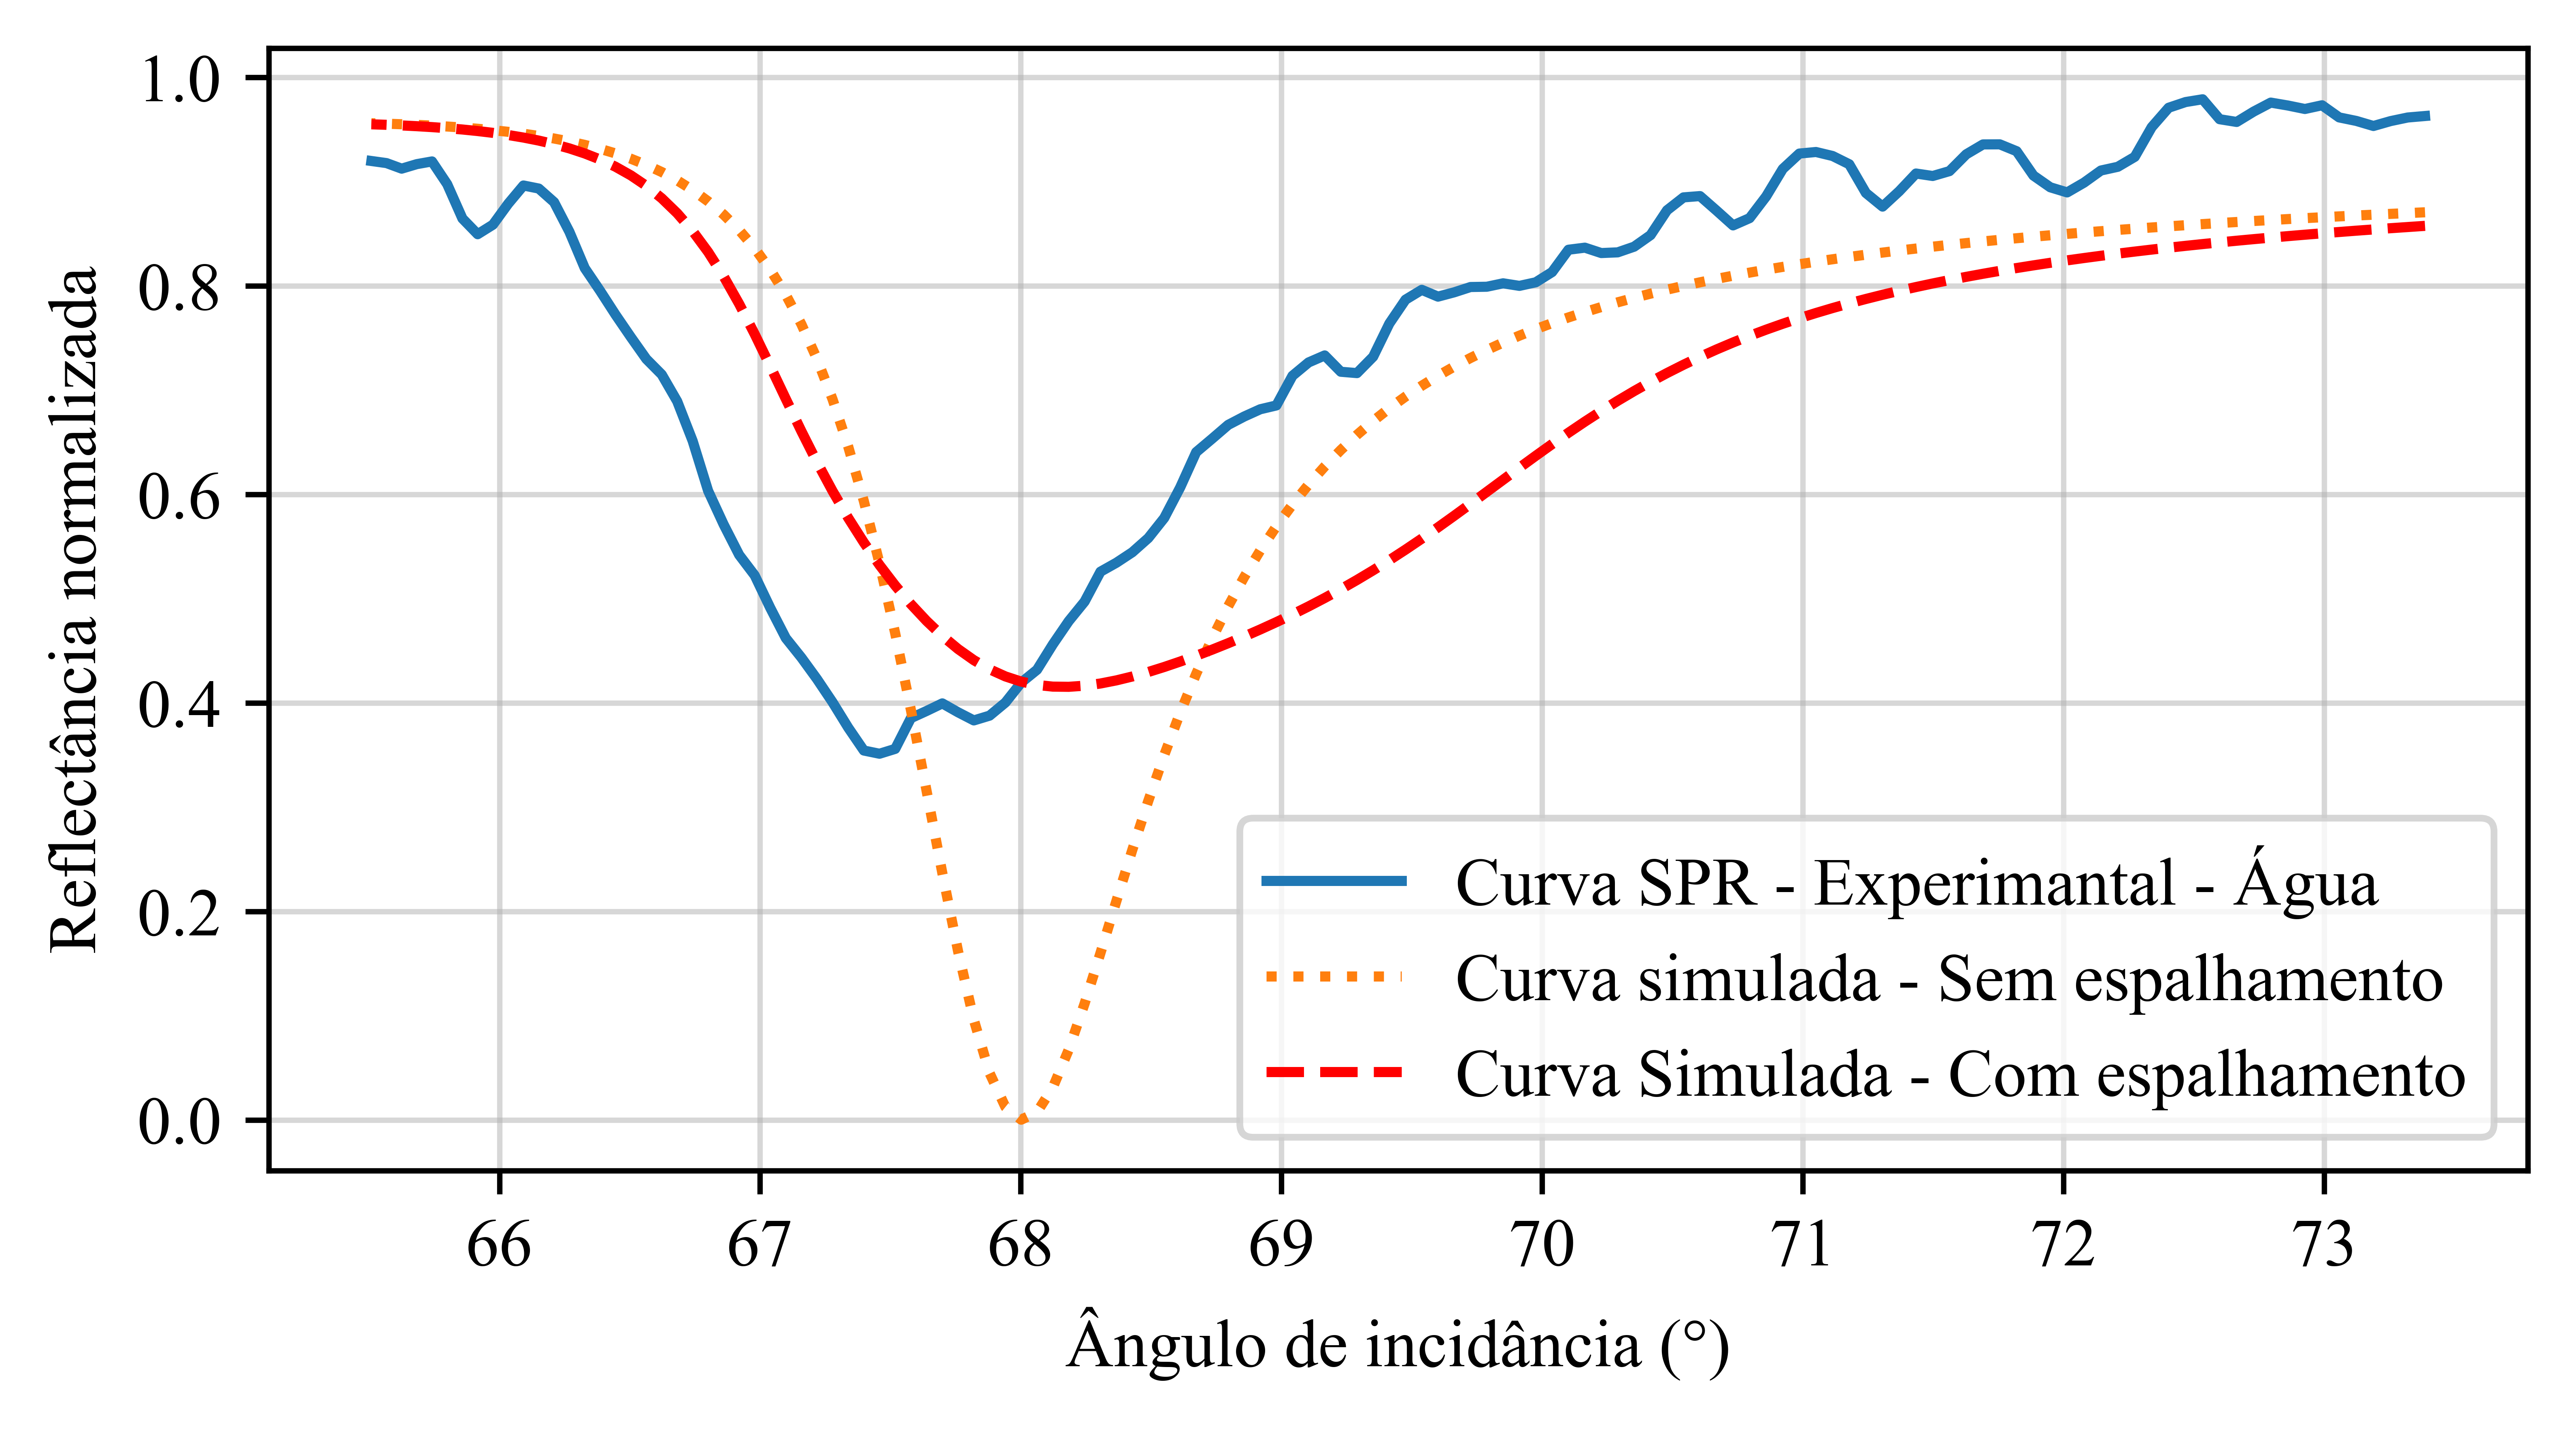

In [89]:
plt.subplots(dpi=1200, figsize=(6,3))
plt.plot(theta_i, signal, '-', label= 'Curva SPR - Experimantal - Água')
plt.plot(theta_i, R,':', label = 'Curva simulada - Sem espalhamento')
plt.plot(theta_i, reflectancia,'--r', label= 'Curva Simulada - Com espalhamento' )
plt.grid(True, alpha=0.5)
plt.legend()
plt.xlabel("Ângulo de incidância (°)")
plt.ylabel("Reflectância normalizada")
plt.show()


## Definição do ruido a ser adicionado

* *noise_space* -> é condiserado a diferenca entre a curva experimental e a curva simulada com espalhamento;

* *noise_term* -> é considerado um ruido gaussiano com media nula e desvio padral da ordem de 40 mV.

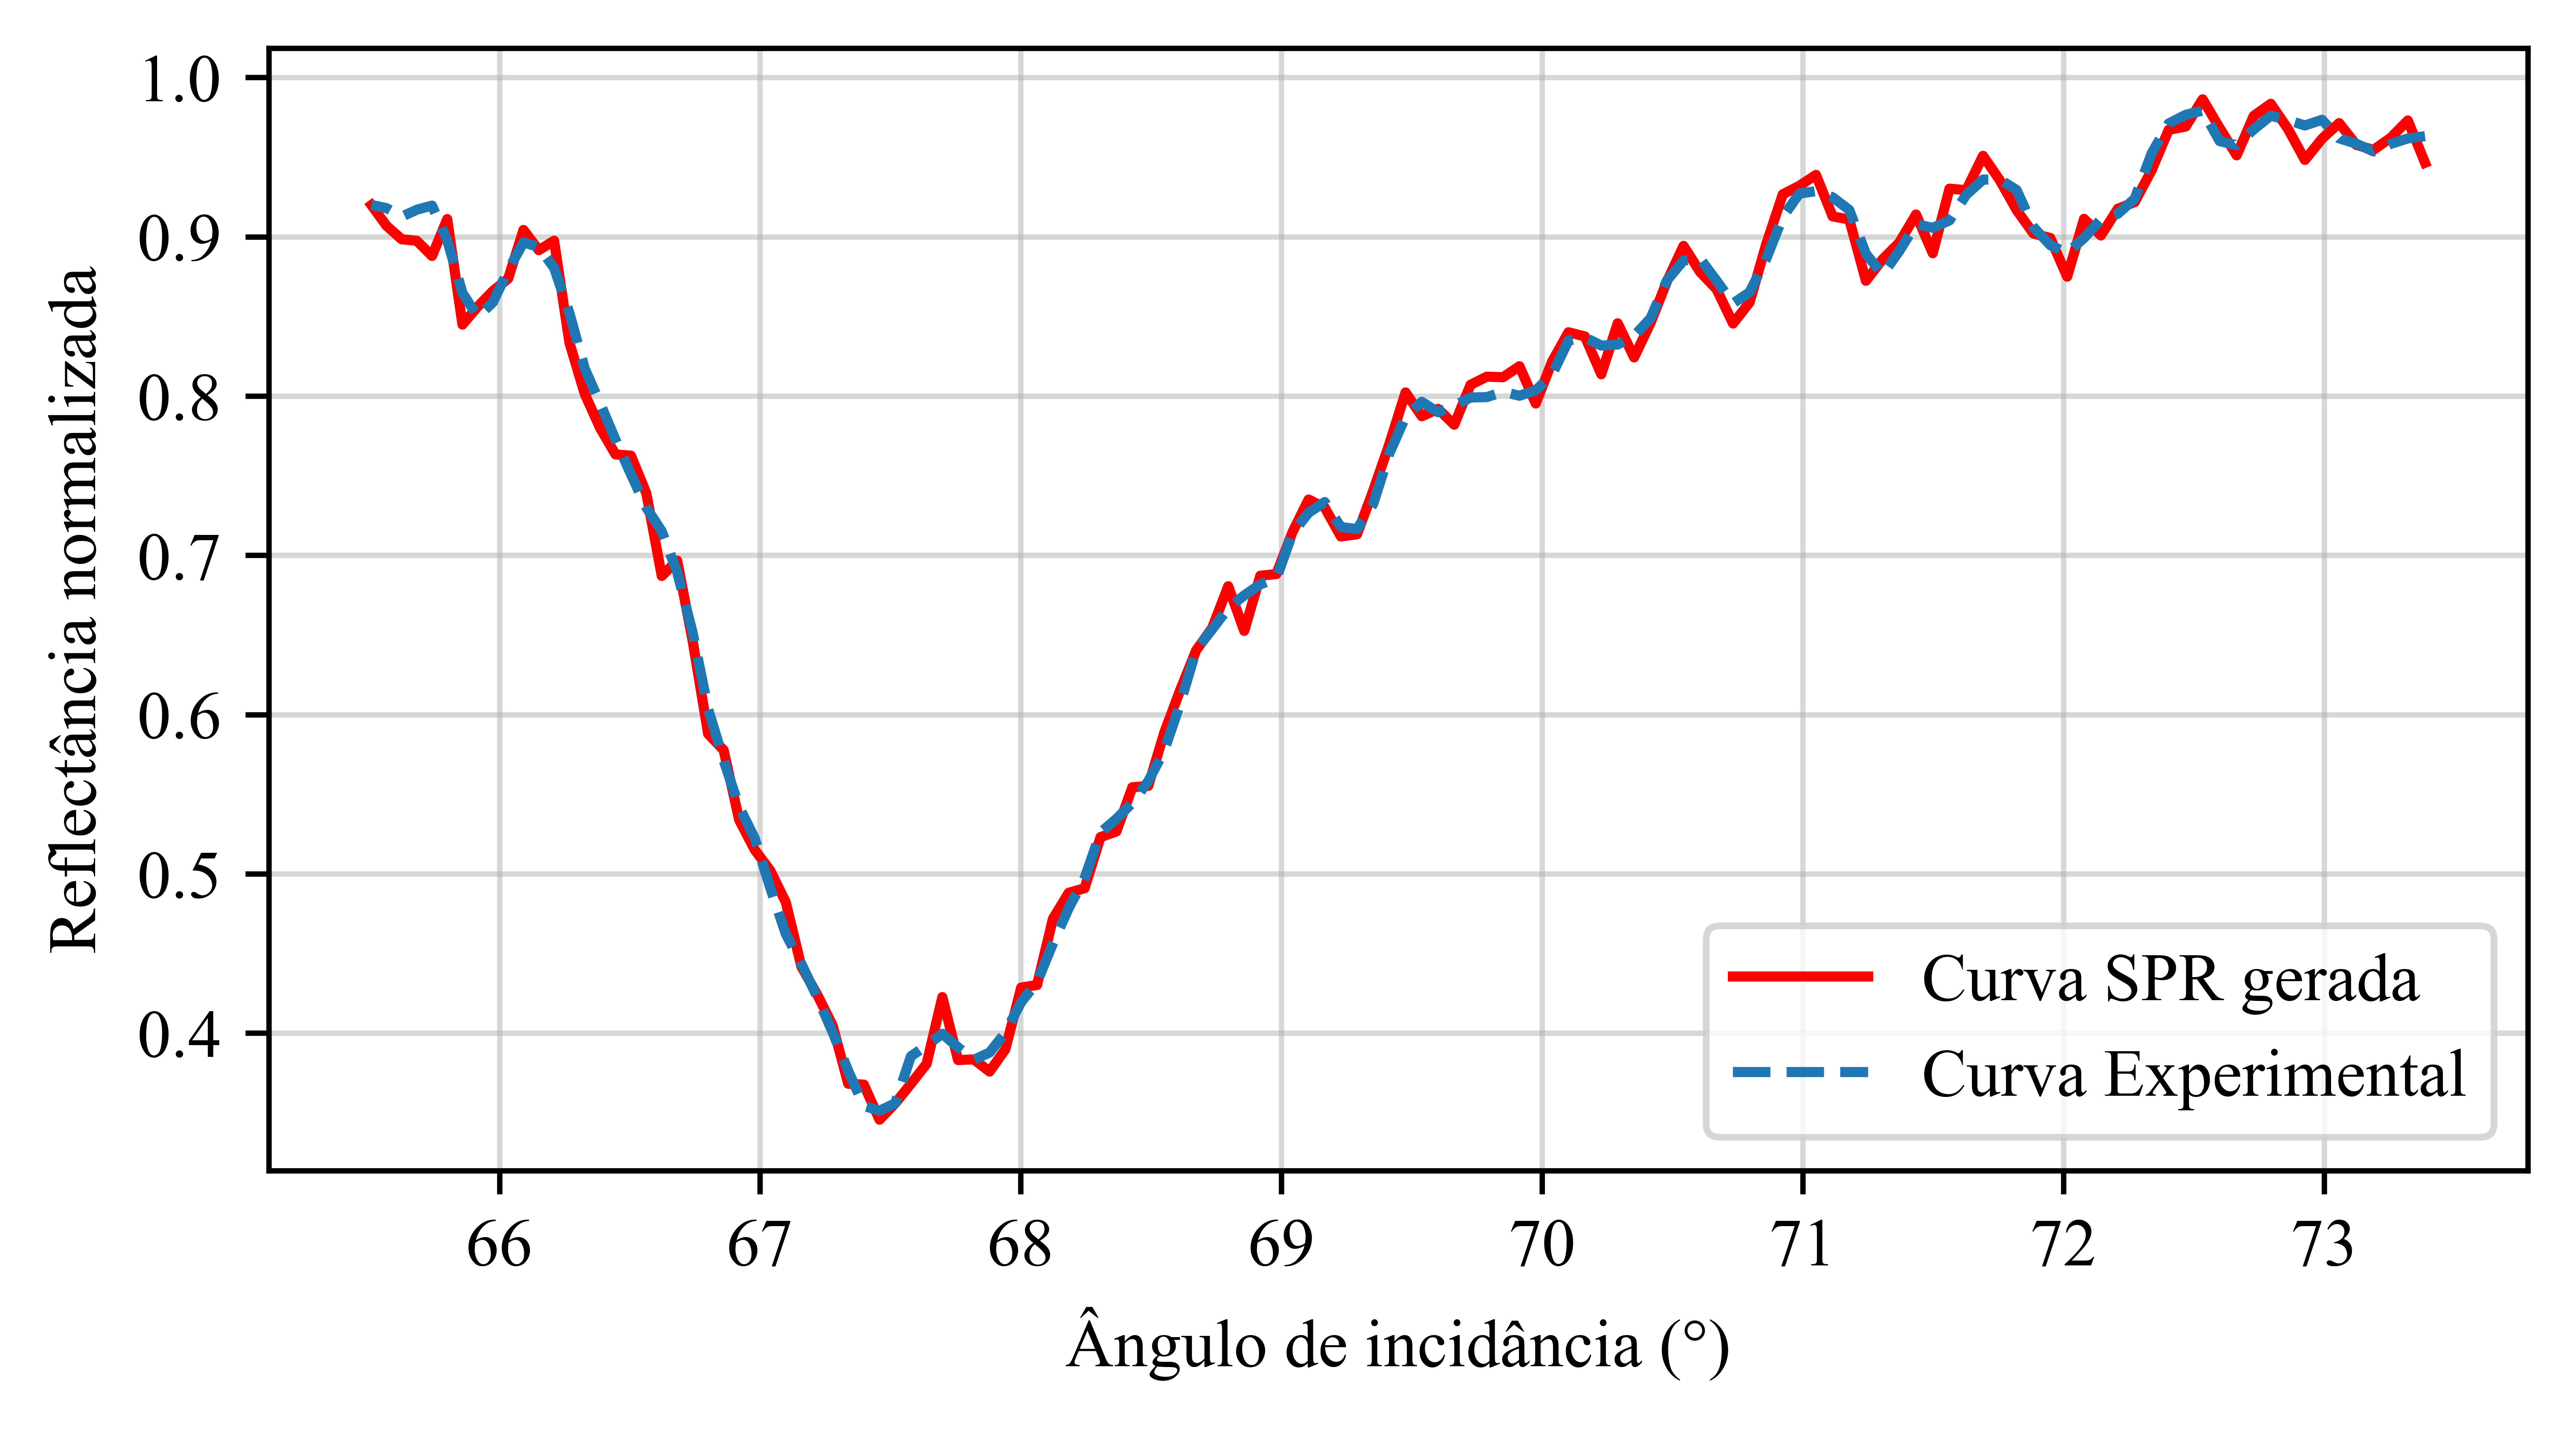

In [90]:
noise_space = []
noise_term = []
for i in range(len(theta_i)):
    noise_space.append((signal[i]) - (reflectancia[i]))
    noise_term.append(gauss(0,0.04)/signal_ref_AR[i])

spr_result = ((reflectancia)) + noise_space + noise_term

plt.subplots(dpi=1200, figsize=(6,3))
plt.plot(theta_i, spr_result,'-r', label="Curva SPR gerada")
plt.plot(theta_i, signal, '--', label = "Curva Experimental")
plt.grid(True, alpha=0.5)
plt.legend()
plt.xlabel("Ângulo de incidância (°)")
plt.ylabel("Reflectância normalizada")

plt.show()

## Algoritmo para cálculo do FWHM e Linha Base

Primeiramente é localizado o mínimo da curva bruta, em seguda a curva SPR é separada em dois segmentos já que a curva é assimética (um a direita do mínimo e outro a esquerda), a partir dos quais são localizados os pontos médios de cada entre o máximo e o mínimo, e a partir dos pontos médios de cada segmento é calculado o ponto médio da curva completa. 

Após isso, a função *sign* faz a verificação de quais valores estão acima ou abaixo do ponto médio, caracterizando-os como: 1, se o valor é maior que o valor médio, ou -1, caso contrário.

Em seguida, as funções *zero_crossings* e *zero_crossings_i* fazem a vericação quando há a troca de sinal, retornando o indice de cada elemento onde há a troca, sendo eles armazenados nas variaveis temporárias *id1* e *j*.

E assim os pontos exatos $X_i$ onde $R(\theta_i) = y_{med} $, são obtidos por interpolação utilizando os valores de $\theta_i$ proximos aos índices *id1* e *id2*.

In [114]:
y = list(spr_result)

id_min = y.index(min(y))

y_left = y[0:id_min]
y_right = y[id_min-1:len(y)]

y_mx_left = max(y_left)
y_mn_left = min(y_left)

y_mx_right = max(y_right)
y_mn_right = min(y_right)

y_med_left = (y_mx_left + y_mn_left)/2
y_med_right = (y_mx_right + y_mn_right)/2

y_med = (y_med_left + y_med_right)/2

signs = sign(add(y, -y_med))

zero_crossings = (signs[0:-2] != signs[1:-1])
zero_crossings_i = where(zero_crossings)[0]

id1 = zero_crossings_i[-1]
id2 = zero_crossings_i[-2]

x1 = theta_i[id1] + (theta_i[id1+1] - theta_i[id1]) * ((y_med - y[id1]) / (y[id1+1] - y[id1]))
x2 = theta_i[id2] + (theta_i[id2+1] - theta_i[id2]) * ((y_med - y[id2]) / (y[id2+1] - y[id2]))

print(f"Ângulos (x1, x2): {x1, x2}")
print(f"Indices correspondentes(id, j): {id1, id2}")

Ângulos (x1, x2): (66.7347015273926, 68.72362488117753)
Indices correspondentes(id, j): (106, 73)


Plotagem da linha de base junto a curva SPR

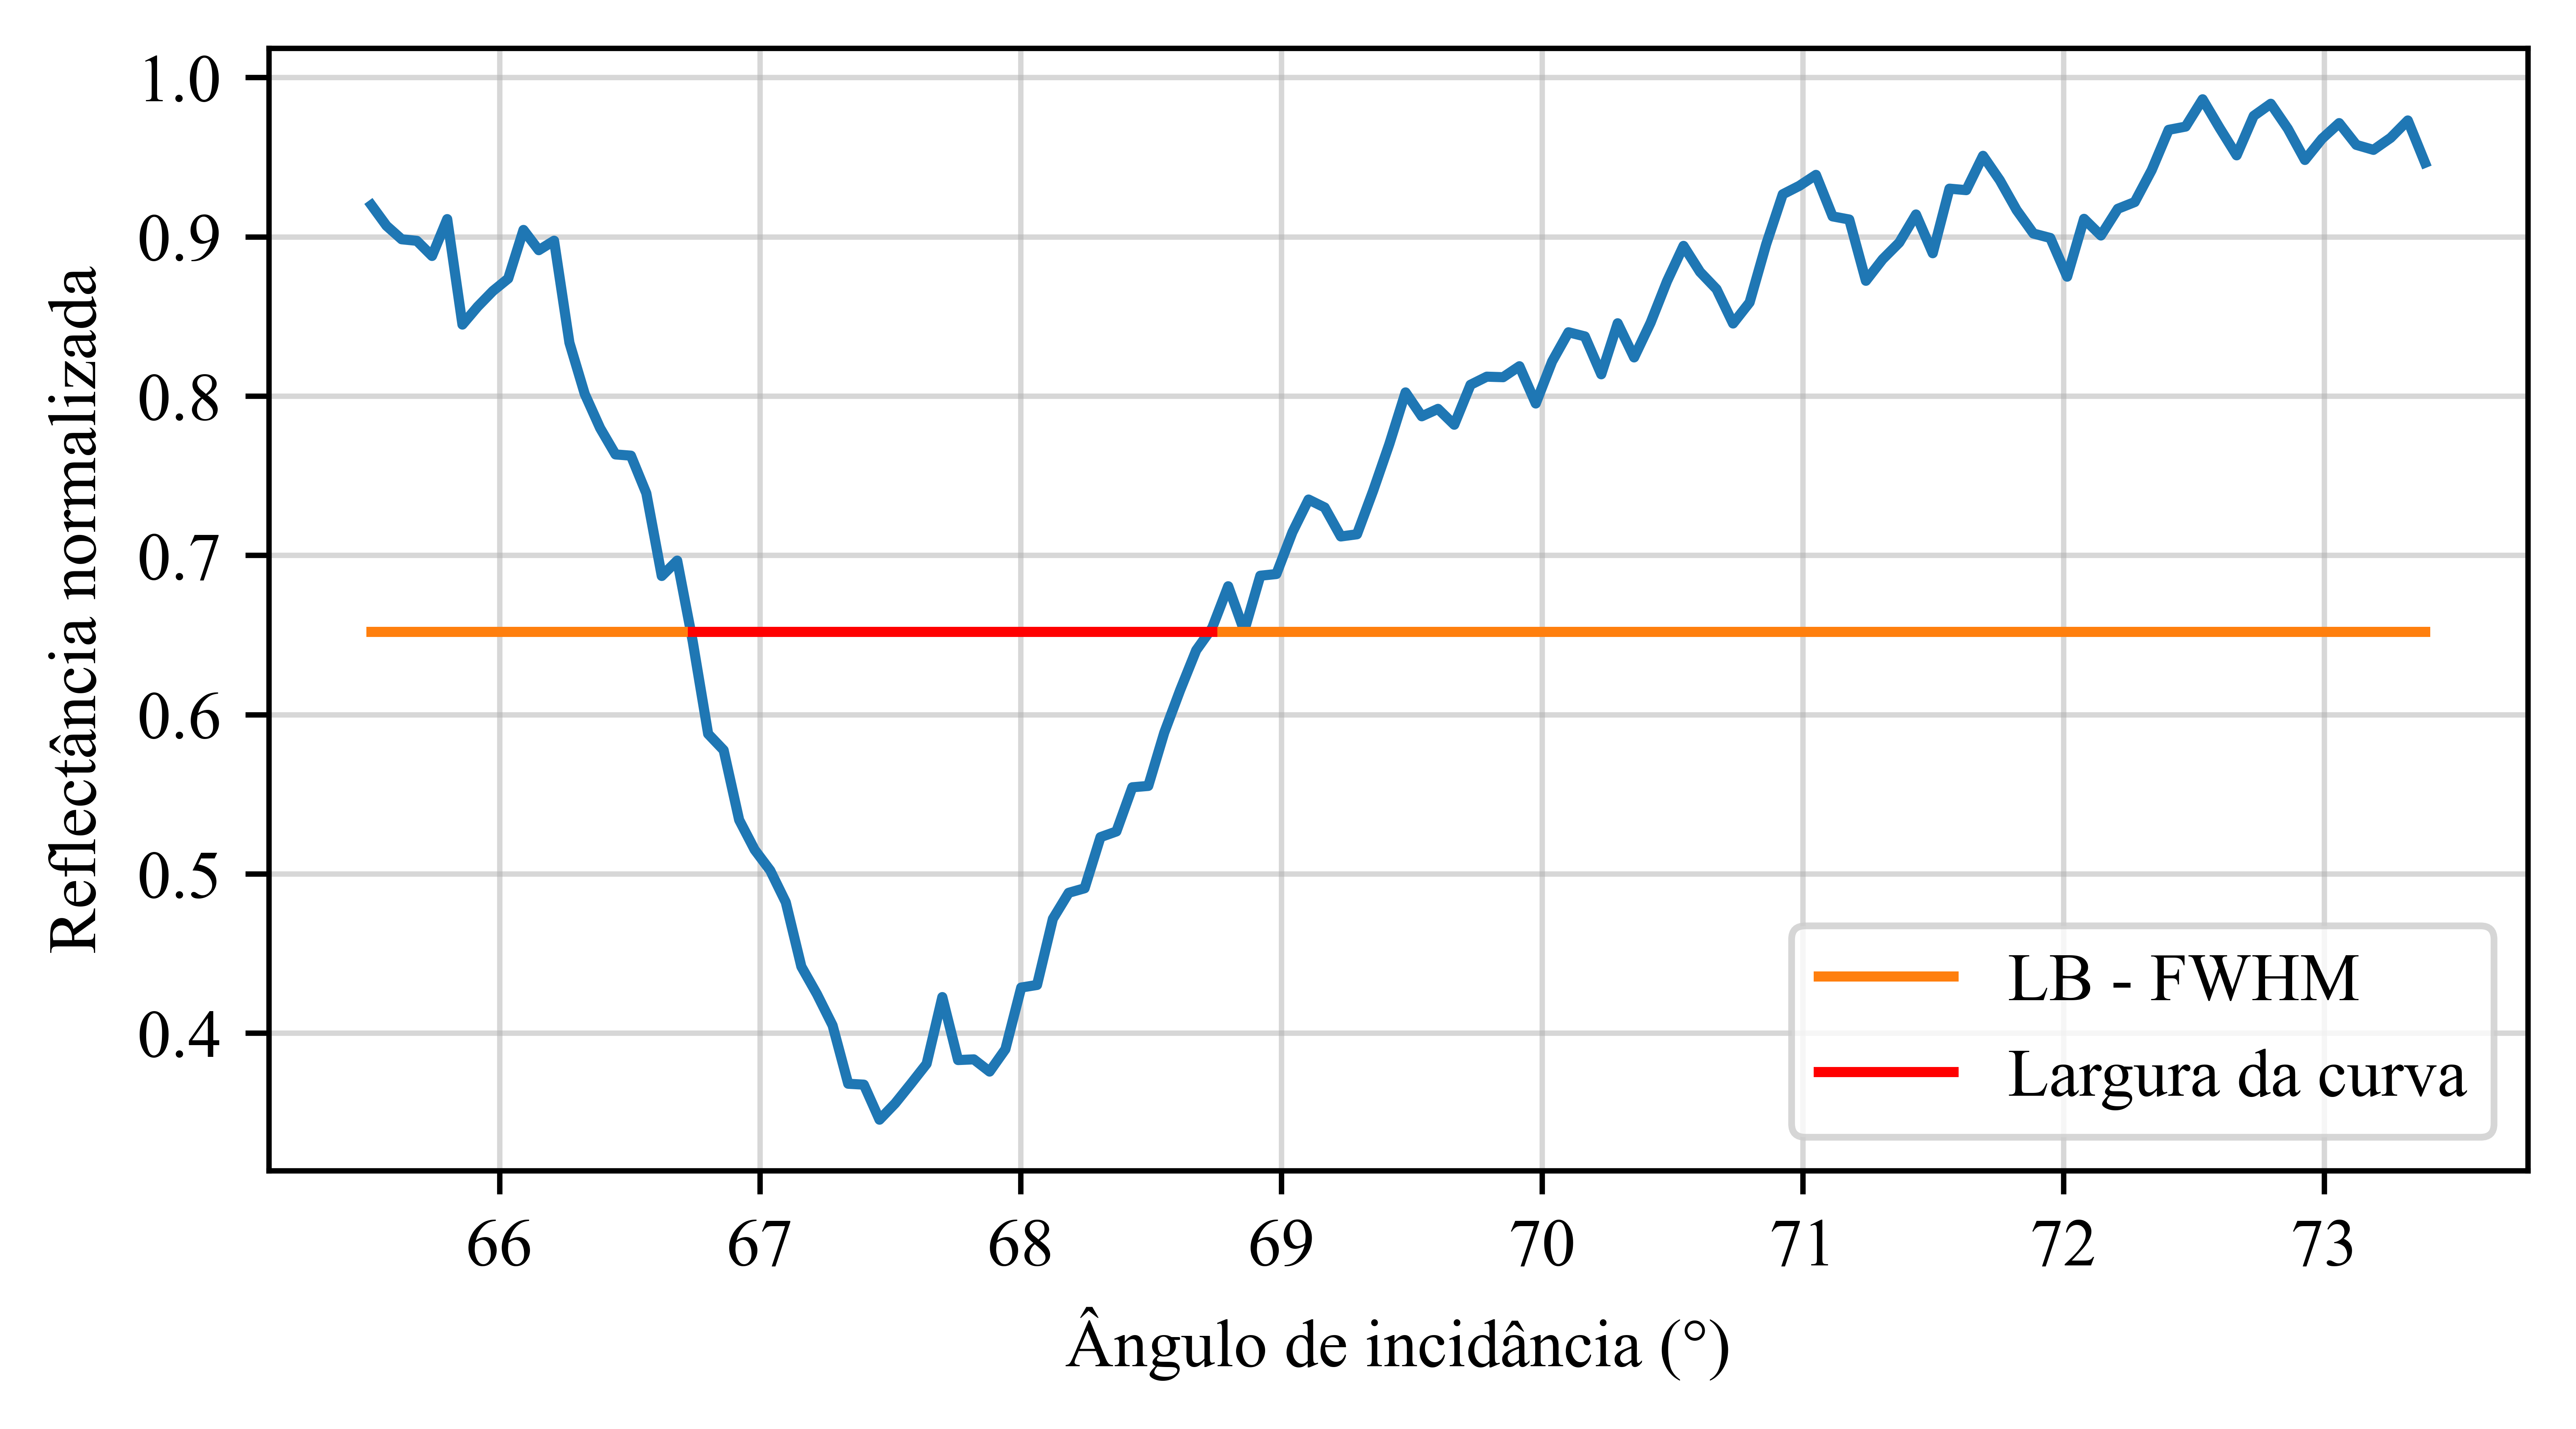

In [115]:
plt.subplots(dpi=1200, figsize=(6,3))
plt.plot(theta_i, y)
plt.plot([theta_i[0], theta_i[-1]], [y_med, y_med], label = "LB - FWHM")
plt.plot([theta_i[id1], theta_i[id2]],[y_med, y_med],  'r',label = "Largura da curva")
plt.grid(True, alpha=0.5)
plt.legend()
plt.xlabel("Ângulo de incidância (°)")
plt.ylabel("Reflectância normalizada")
plt.show()

## Filtragem do sinal

Definição da função que projeta o filtro passa-baixas *Butterworth*. (*b, a*) são os coeficientes do numerador e denominador da resposta do filtro; a função *filtfilt()* aplica os coeficientes e faz a filtragem do sinal repassado no parâmetro *data*.

In [116]:
def butter_lowpass_filter(data, cutoff, fs, order):
    # Get the filter coefficients 
    b, a = butter(order, cutoff, btype='low', fs = fs)
    y = filtfilt(b, a, data)
    return y

Comparativo entre os algoritmos de filtragem
    
* (1) Filtro Media móvel exponencial (*signal_me*);

* (2) Filtro passa-baixas Butterworth (*signal_filtered_*). 

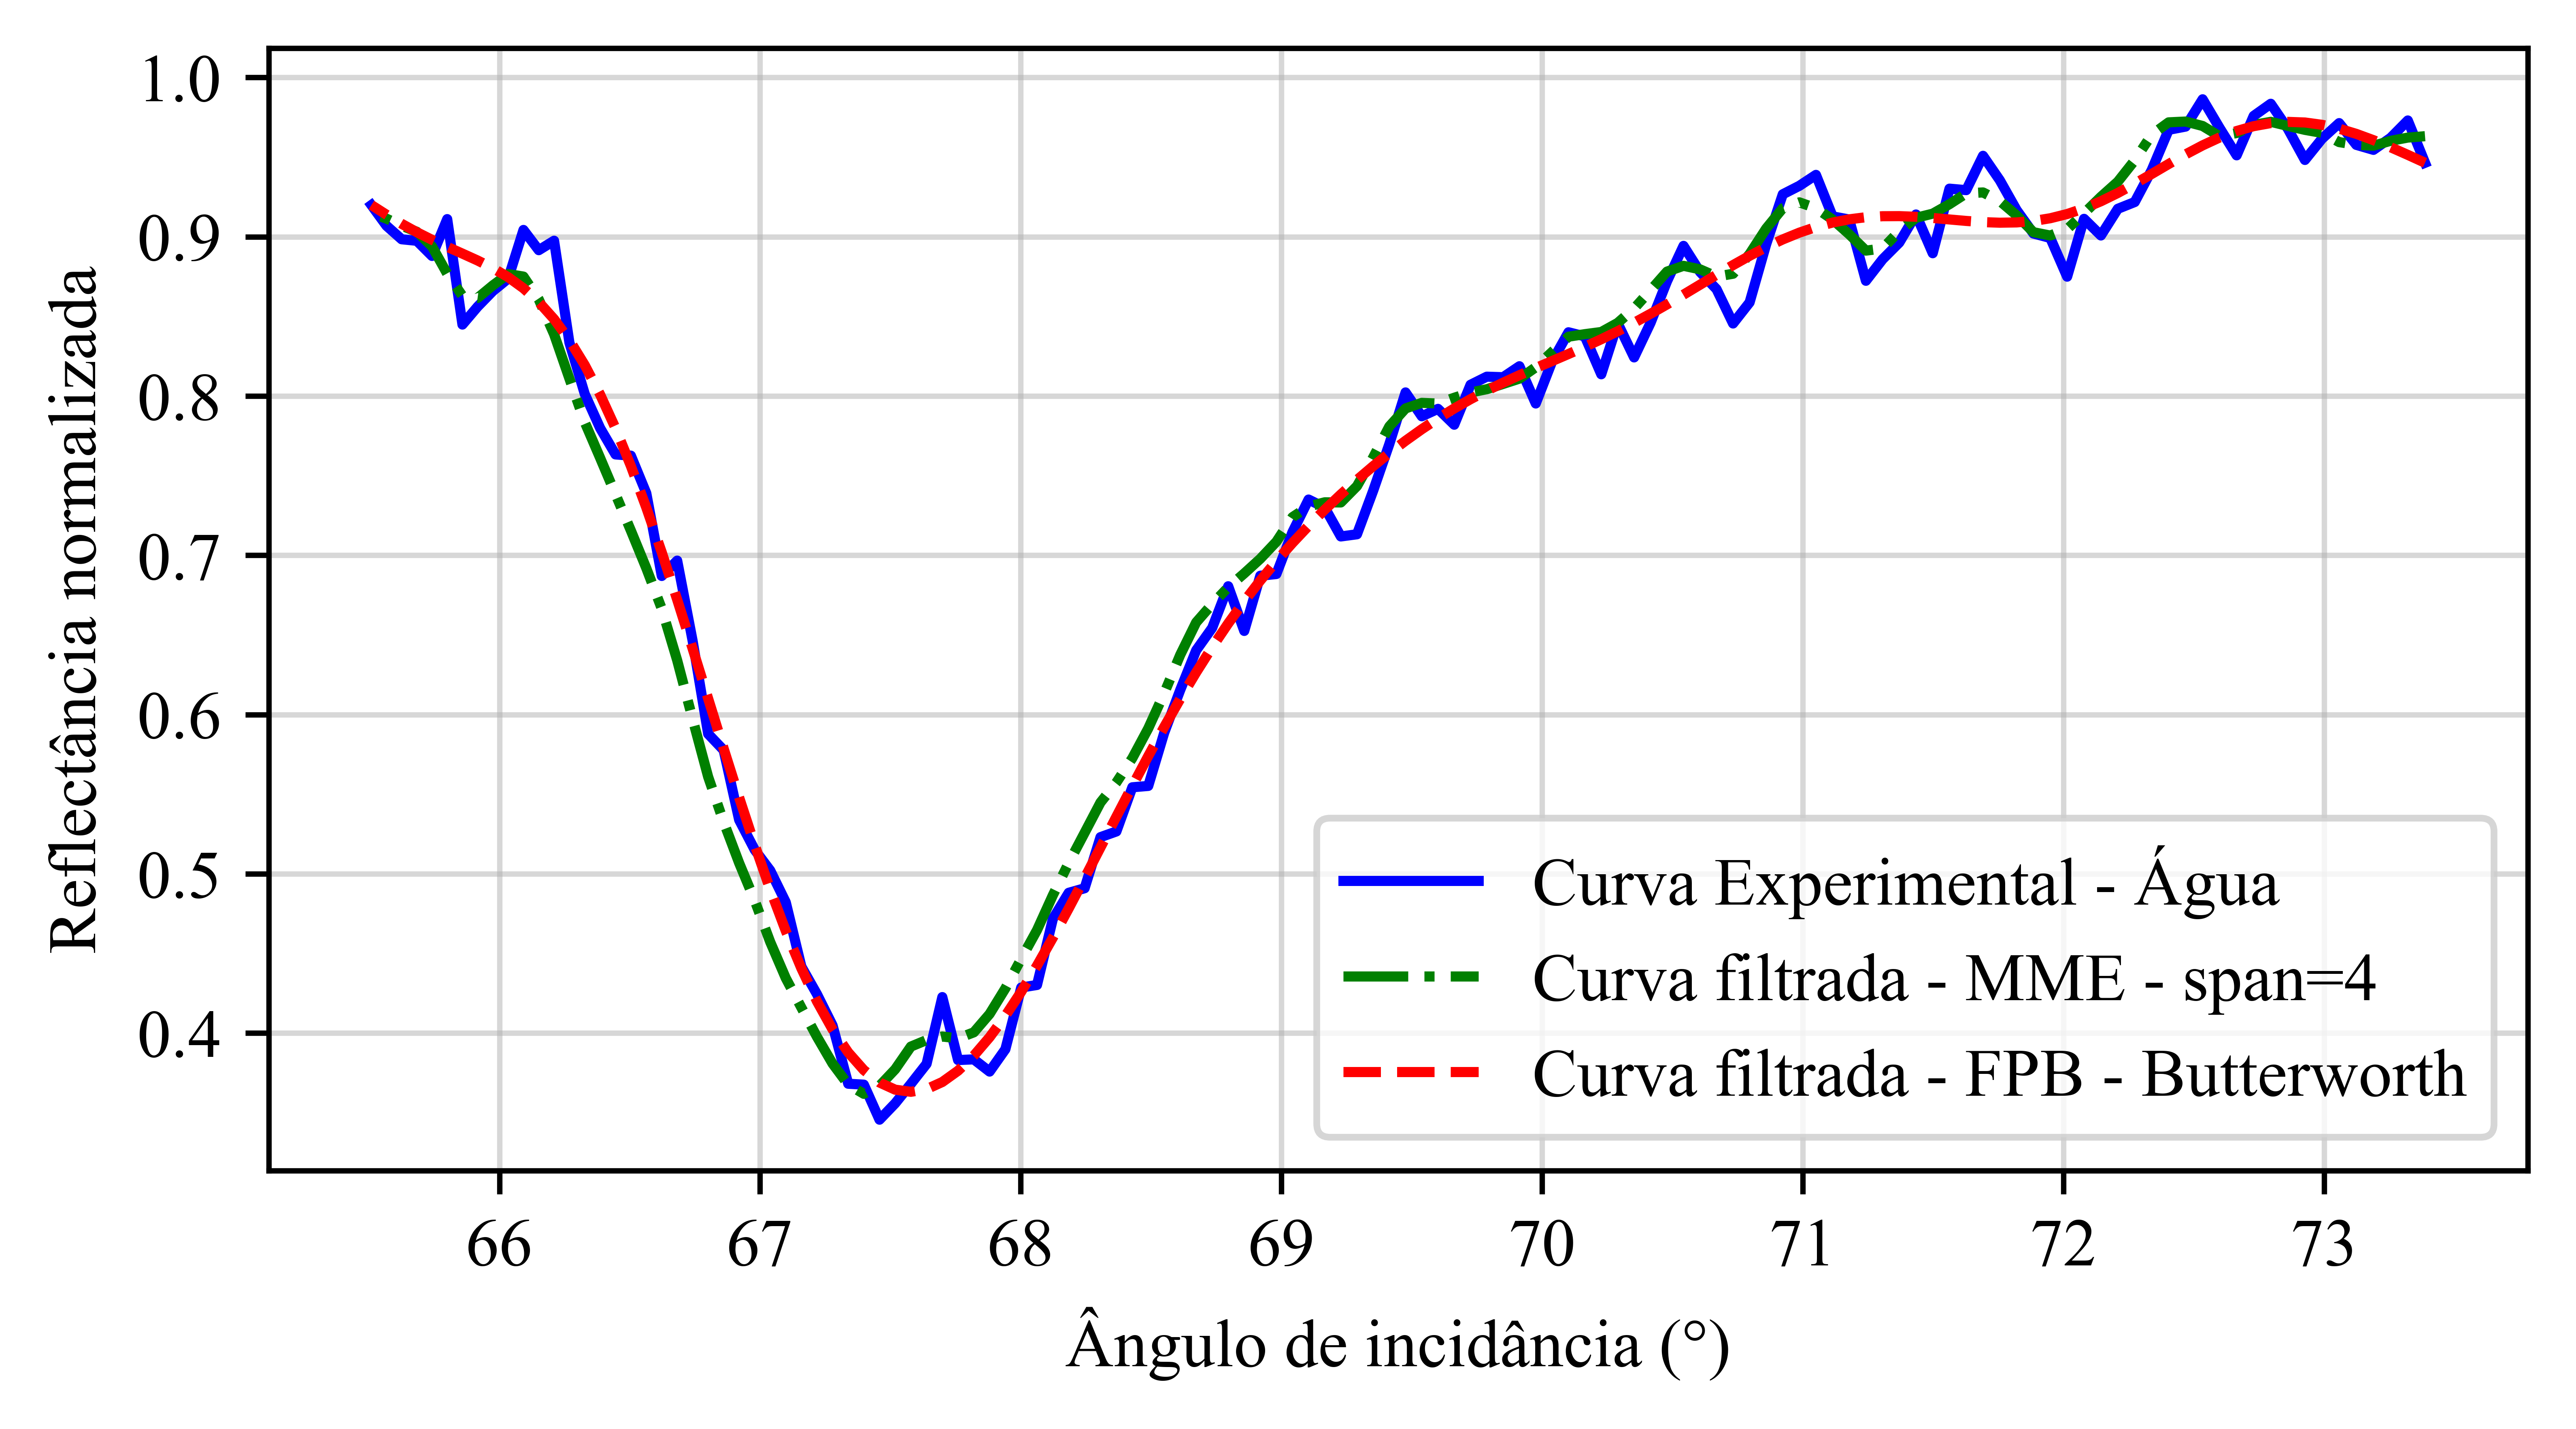

In [125]:
signal_me = signal.ewm(span=4).mean()
signal_filtered_ = list(butter_lowpass_filter(spr_result, cutoff=2, fs=40, order=5))

plt.subplots(dpi=1200, figsize=(6,3))
plt.plot(theta_i, spr_result,'-b' ,label='Curva Experimental - Água')
plt.plot(theta_i, signal_me, '-.g', label='Curva filtrada - MME - span=4')
plt.plot(theta_i, signal_filtered_,'--r' ,label='Curva filtrada - FPB - Butterworth')
plt.grid(True, alpha=0.5)
plt.legend()
plt.xlabel("Ângulo de incidância (°)")
plt.ylabel("Reflectância normalizada")
plt.show()


Ajuste da curva considerando apenas os dados abaixo da linha de base 

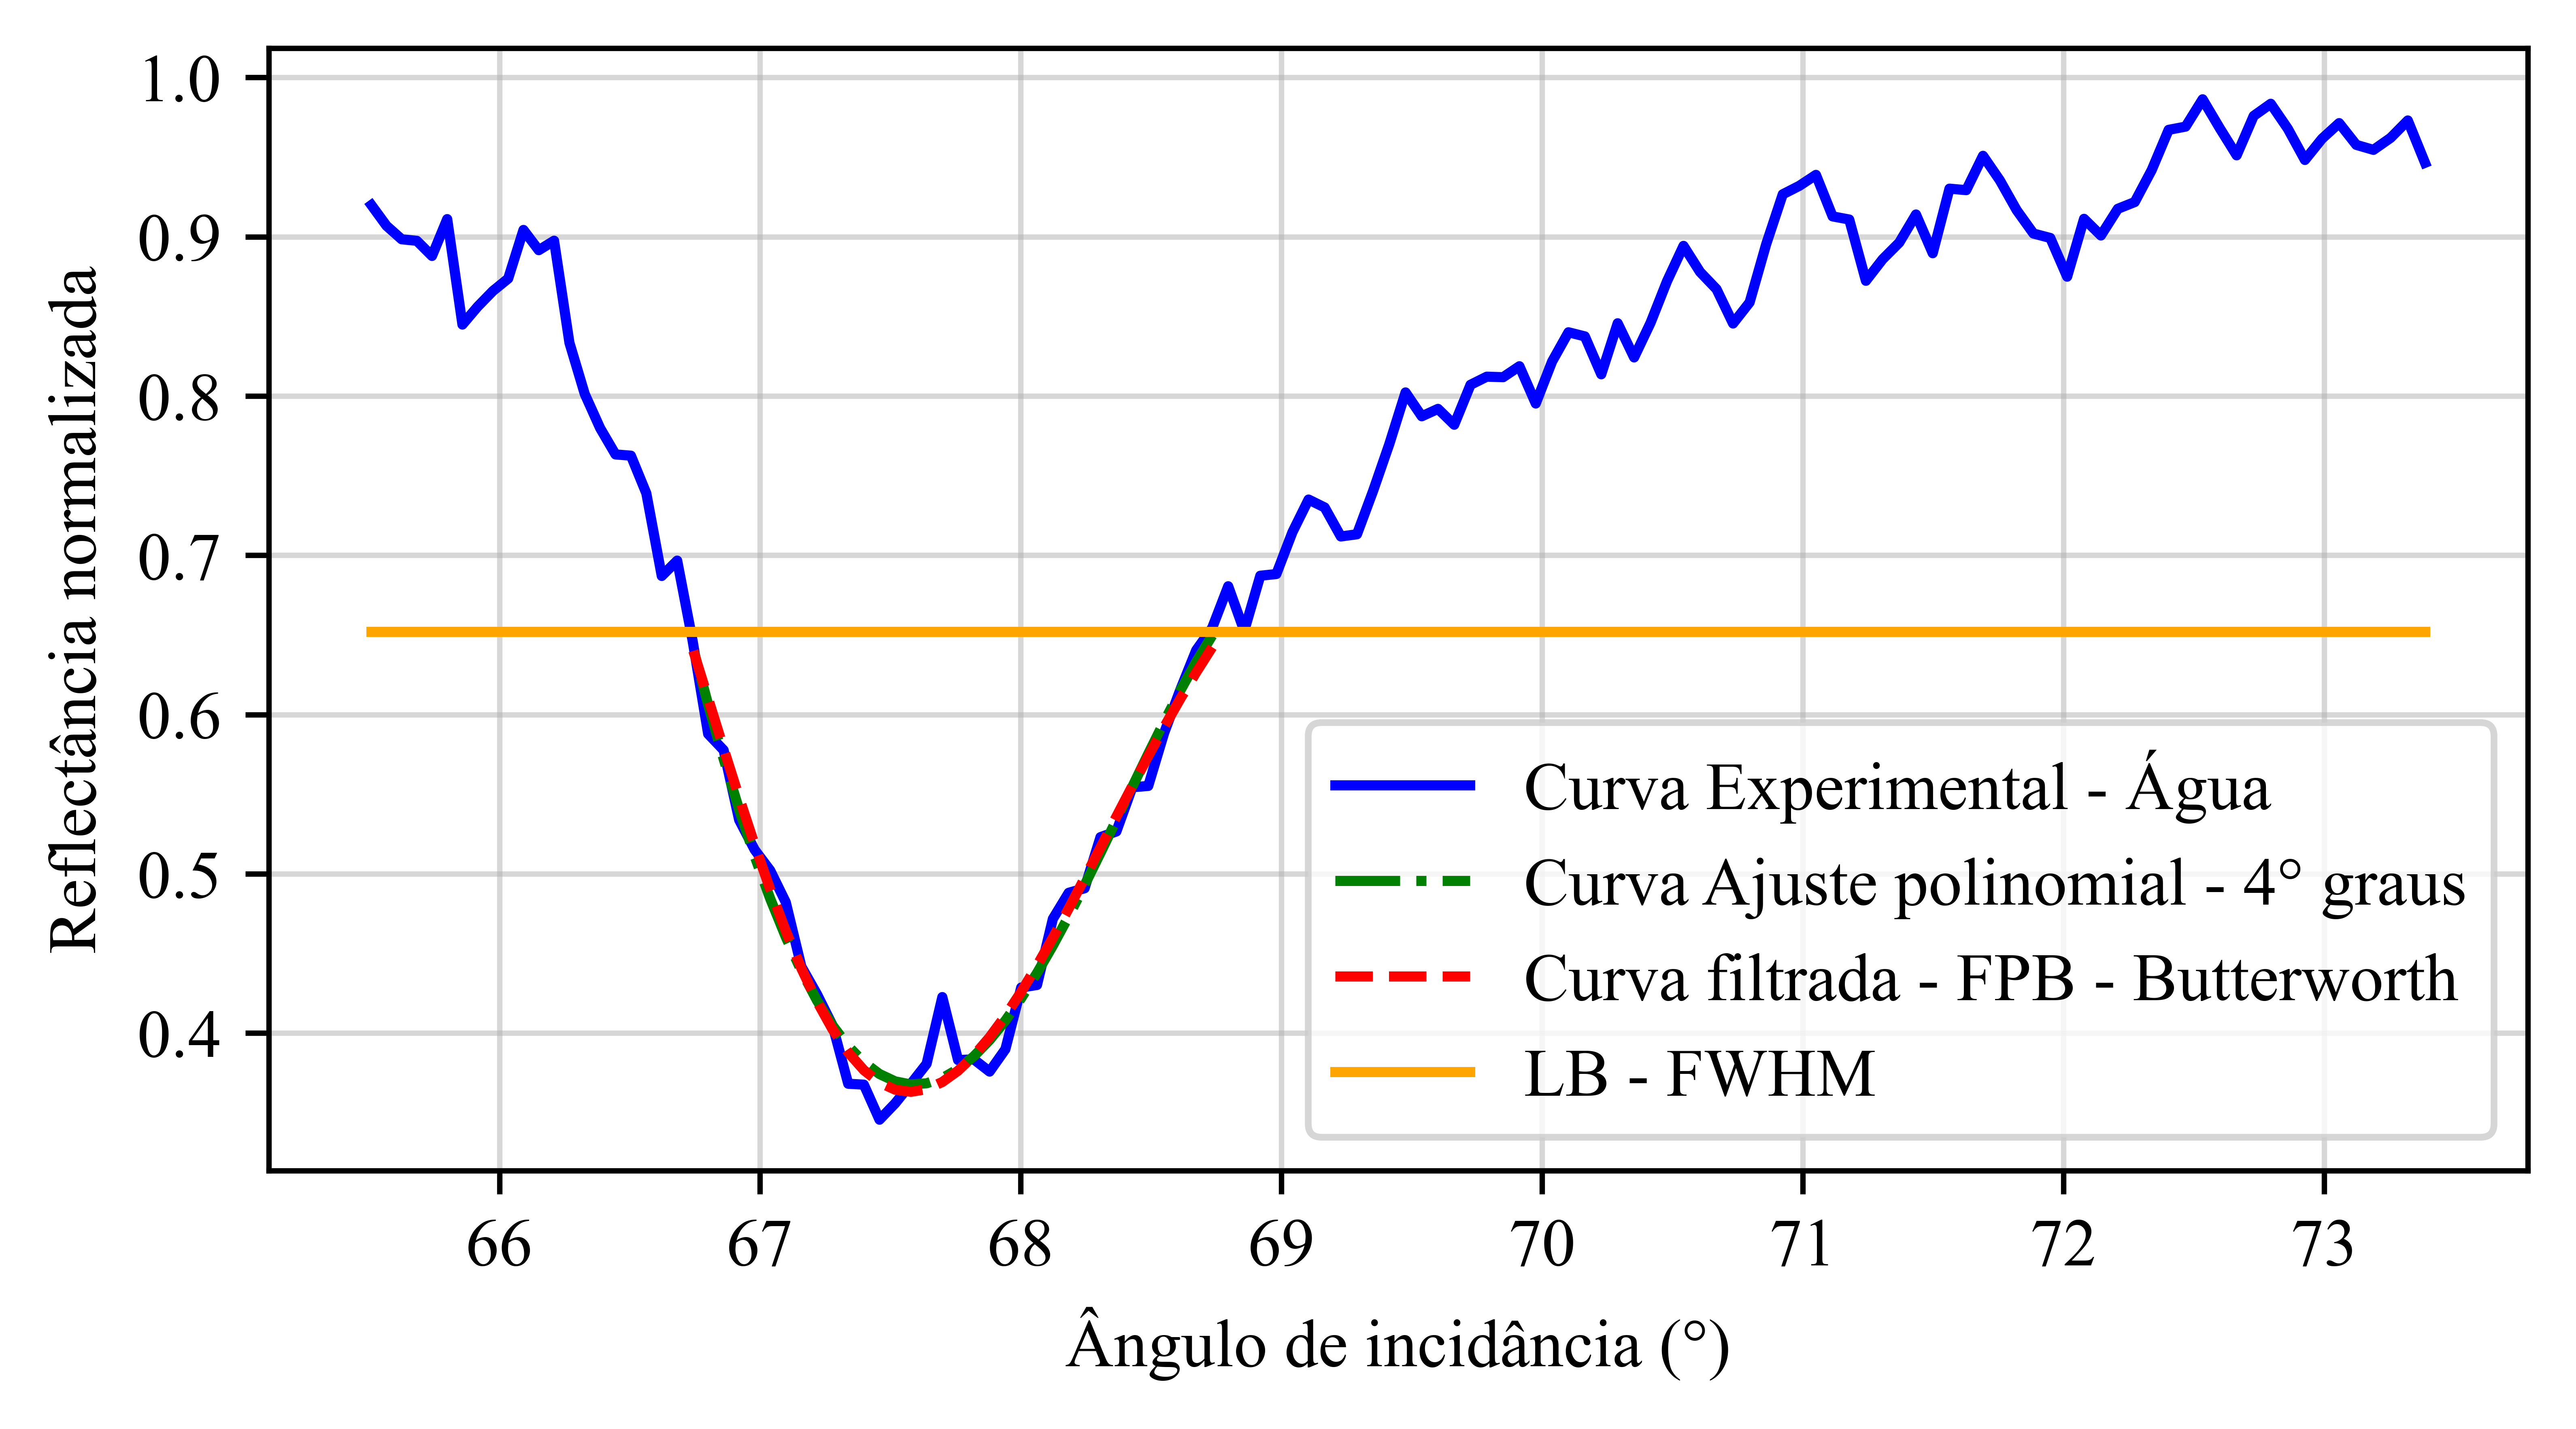

In [127]:
r = list(spr_result)

x = theta_i[id2 : id1+1]
y = r[id2 : id1+1]

z = Polynomial.fit(x, y, 4)

yz = []
for i in x:
    yz.append(z(i))

signal_filtered = signal_filtered_[id2 : id1+1]

plt.subplots(dpi=1200, figsize=(6,3))
plt.plot(theta_i, spr_result,'-b' ,label='Curva Experimental - Água')
plt.plot(x, yz, '-.g', label='Curva Ajuste polinomial - 4° graus')
plt.plot(x, signal_filtered,'--r' ,label='Curva filtrada - FPB - Butterworth')
plt.plot([theta_i[0], theta_i[-1]], [y_med, y_med], "orange", label = "LB - FWHM")
plt.grid(True, alpha=0.5)
plt.legend()
plt.xlabel("Ângulo de incidância (°)")
plt.ylabel("Reflectância normalizada")
plt.show()


## Cálculo do ângulo de ressonância 

(1) Considerando a busca do minimo pela função *optimize.fminbound()*;

(2) Considerando o rastreamento direto do valor mínimo da curva.

In [128]:
# Mínimo da função de interpolação pela função 'optimize.fminbound()'
res_angle = optimize.fminbound(z, theta_i[(id1+1)] ,theta_i[(id2)] ) 

# Mínimo do sinal filtrado por rastreamento
idx1 =  yz.index(min(yz))
res_angle_2 = x[idx1]


(3) Método do Centróide - LB fixa

In [129]:
LB = y_med
soma_num = 0
soma_den = 0
for i in range(len(x)):
    b = (LB - signal_filtered[i]) * x[i]
    c = (LB - signal_filtered[i])
    soma_num = soma_num + b
    soma_den = soma_den + c

res_angle_3 = soma_num/soma_den

Comparativo entre os 3 métodos, quanto ao índice de refração, ângulo de ressonacia e pixel de ressonâcia 

In [145]:
res_ang = [res_angle, res_angle_2, res_angle_3]
print("___________________________________________________")
print(" Indice de refração | Ângulo de ressonância | Pixel")
print("___________________________________________________")
for theta in res_ang:
    n_au = sl.set_index(13, 850*1E-9)
    emr = real(n_au)**2 - imag(n_au)**2

    index_analyte = sqrt((emr*(1.4826 * sin(theta*pi/180))**2)/
    (emr-(1.4826*sin(theta*pi/180))**2))

    print(f" {index_analyte:.16f} | {theta:.18f} |  {pixel[id2+idx1]}")
    print("___________________________________________________")

    

___________________________________________________
 Indice de refração | Ângulo de ressonância | Pixel
___________________________________________________
 1.3272621338087722 | 67.592278570178734753 |  93
___________________________________________________
 1.3271398891984252 | 67.578633777999996823 |  93
___________________________________________________
 1.3278809397498901 | 67.661474067562991763 |  93
___________________________________________________


Gráfico mostrando um comparativo entre os métodos de rastreamento

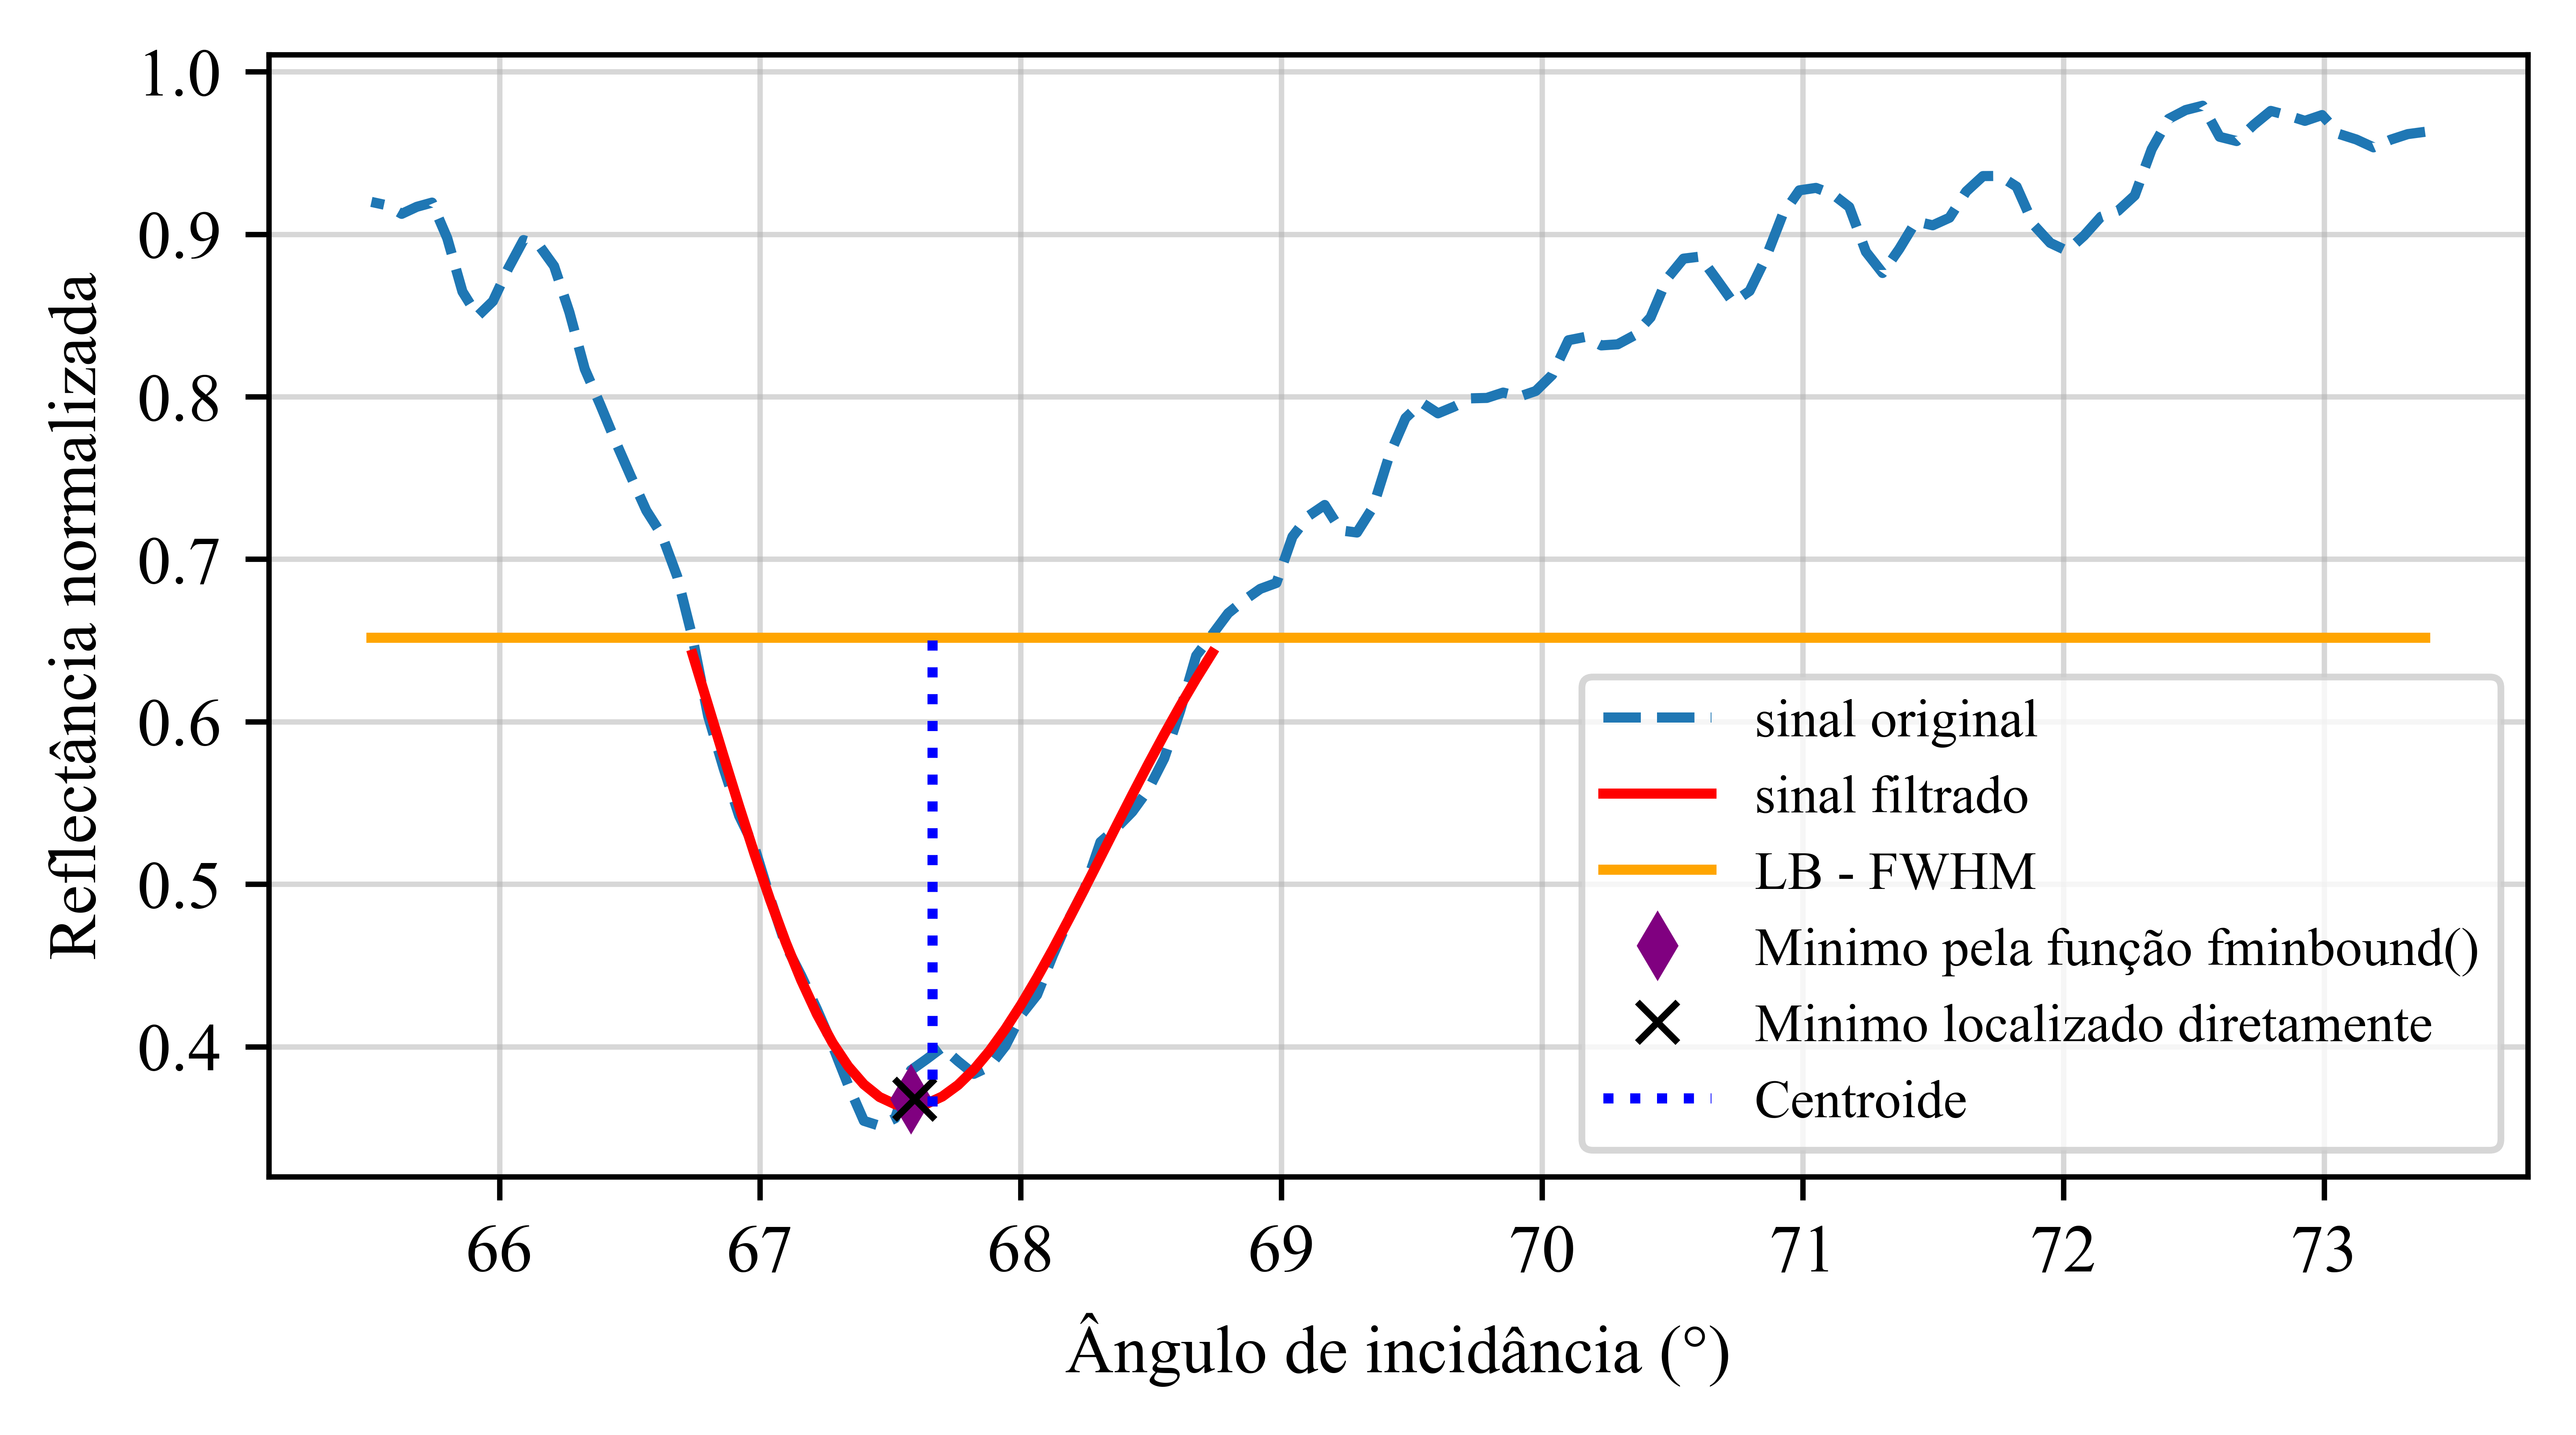

In [147]:
plt.subplots(dpi=1200, figsize=(6,3))
plt.plot(theta_i, signal,'--', label='sinal original')
plt.plot(x, signal_filtered, '-r',label='sinal filtrado')
plt.plot(theta_i, linspace(y_med, y_med, len(theta_i)), 'orange', label = "LB - FWHM")
plt.plot(res_angle_2, min(yz), 'd', color='purple', label='Minimo pela função fminbound()' )
plt.plot(res_angle, min(yz), 'x', color='black', label='Minimo localizado diretamente' )
plt.vlines(res_angle_3, ymax=y_med, ymin=min(signal_filtered), color='b', linestyles='dotted', label='Centroide')
plt.grid(True, alpha=0.5)
plt.legend(fontsize=8)
plt.xlabel("Ângulo de incidância (°)")
plt.ylabel("Reflectância normalizada")
plt.show()

# Criação do arquivo que salva os dados básicos da curva de referência

São armazenados: número do pixel, ângulo de incidência, valor de referência para aquele ângulo, ruído térmico e ruído espacial correspondente a diferenca entre as curvas teóricas e experimental.

In [ ]:
arquivo = open('Reference_data_wet.csv','w')
arquivo.write("Pixel #,Angle,Signal,Noise_Ref,Noise_term,Noise_space")
for i in range(len(theta_i)):
    arquivo.write(f"\n{pixel[i]},{theta_i[i]},{reflectancia[i]},{signal_ref_AR[i]},{noise_term[i]},{noise_space[i]}")
arquivo.close()

## A partir daqui se dará o cálculo das curvas para um analito qualquer a partir do sensorgrama gerado pelo *software SPREETA5*

* *raw_data.csv* -> arquivo gerado pelo *software* contendo os índices de refração ao longo do tempo.

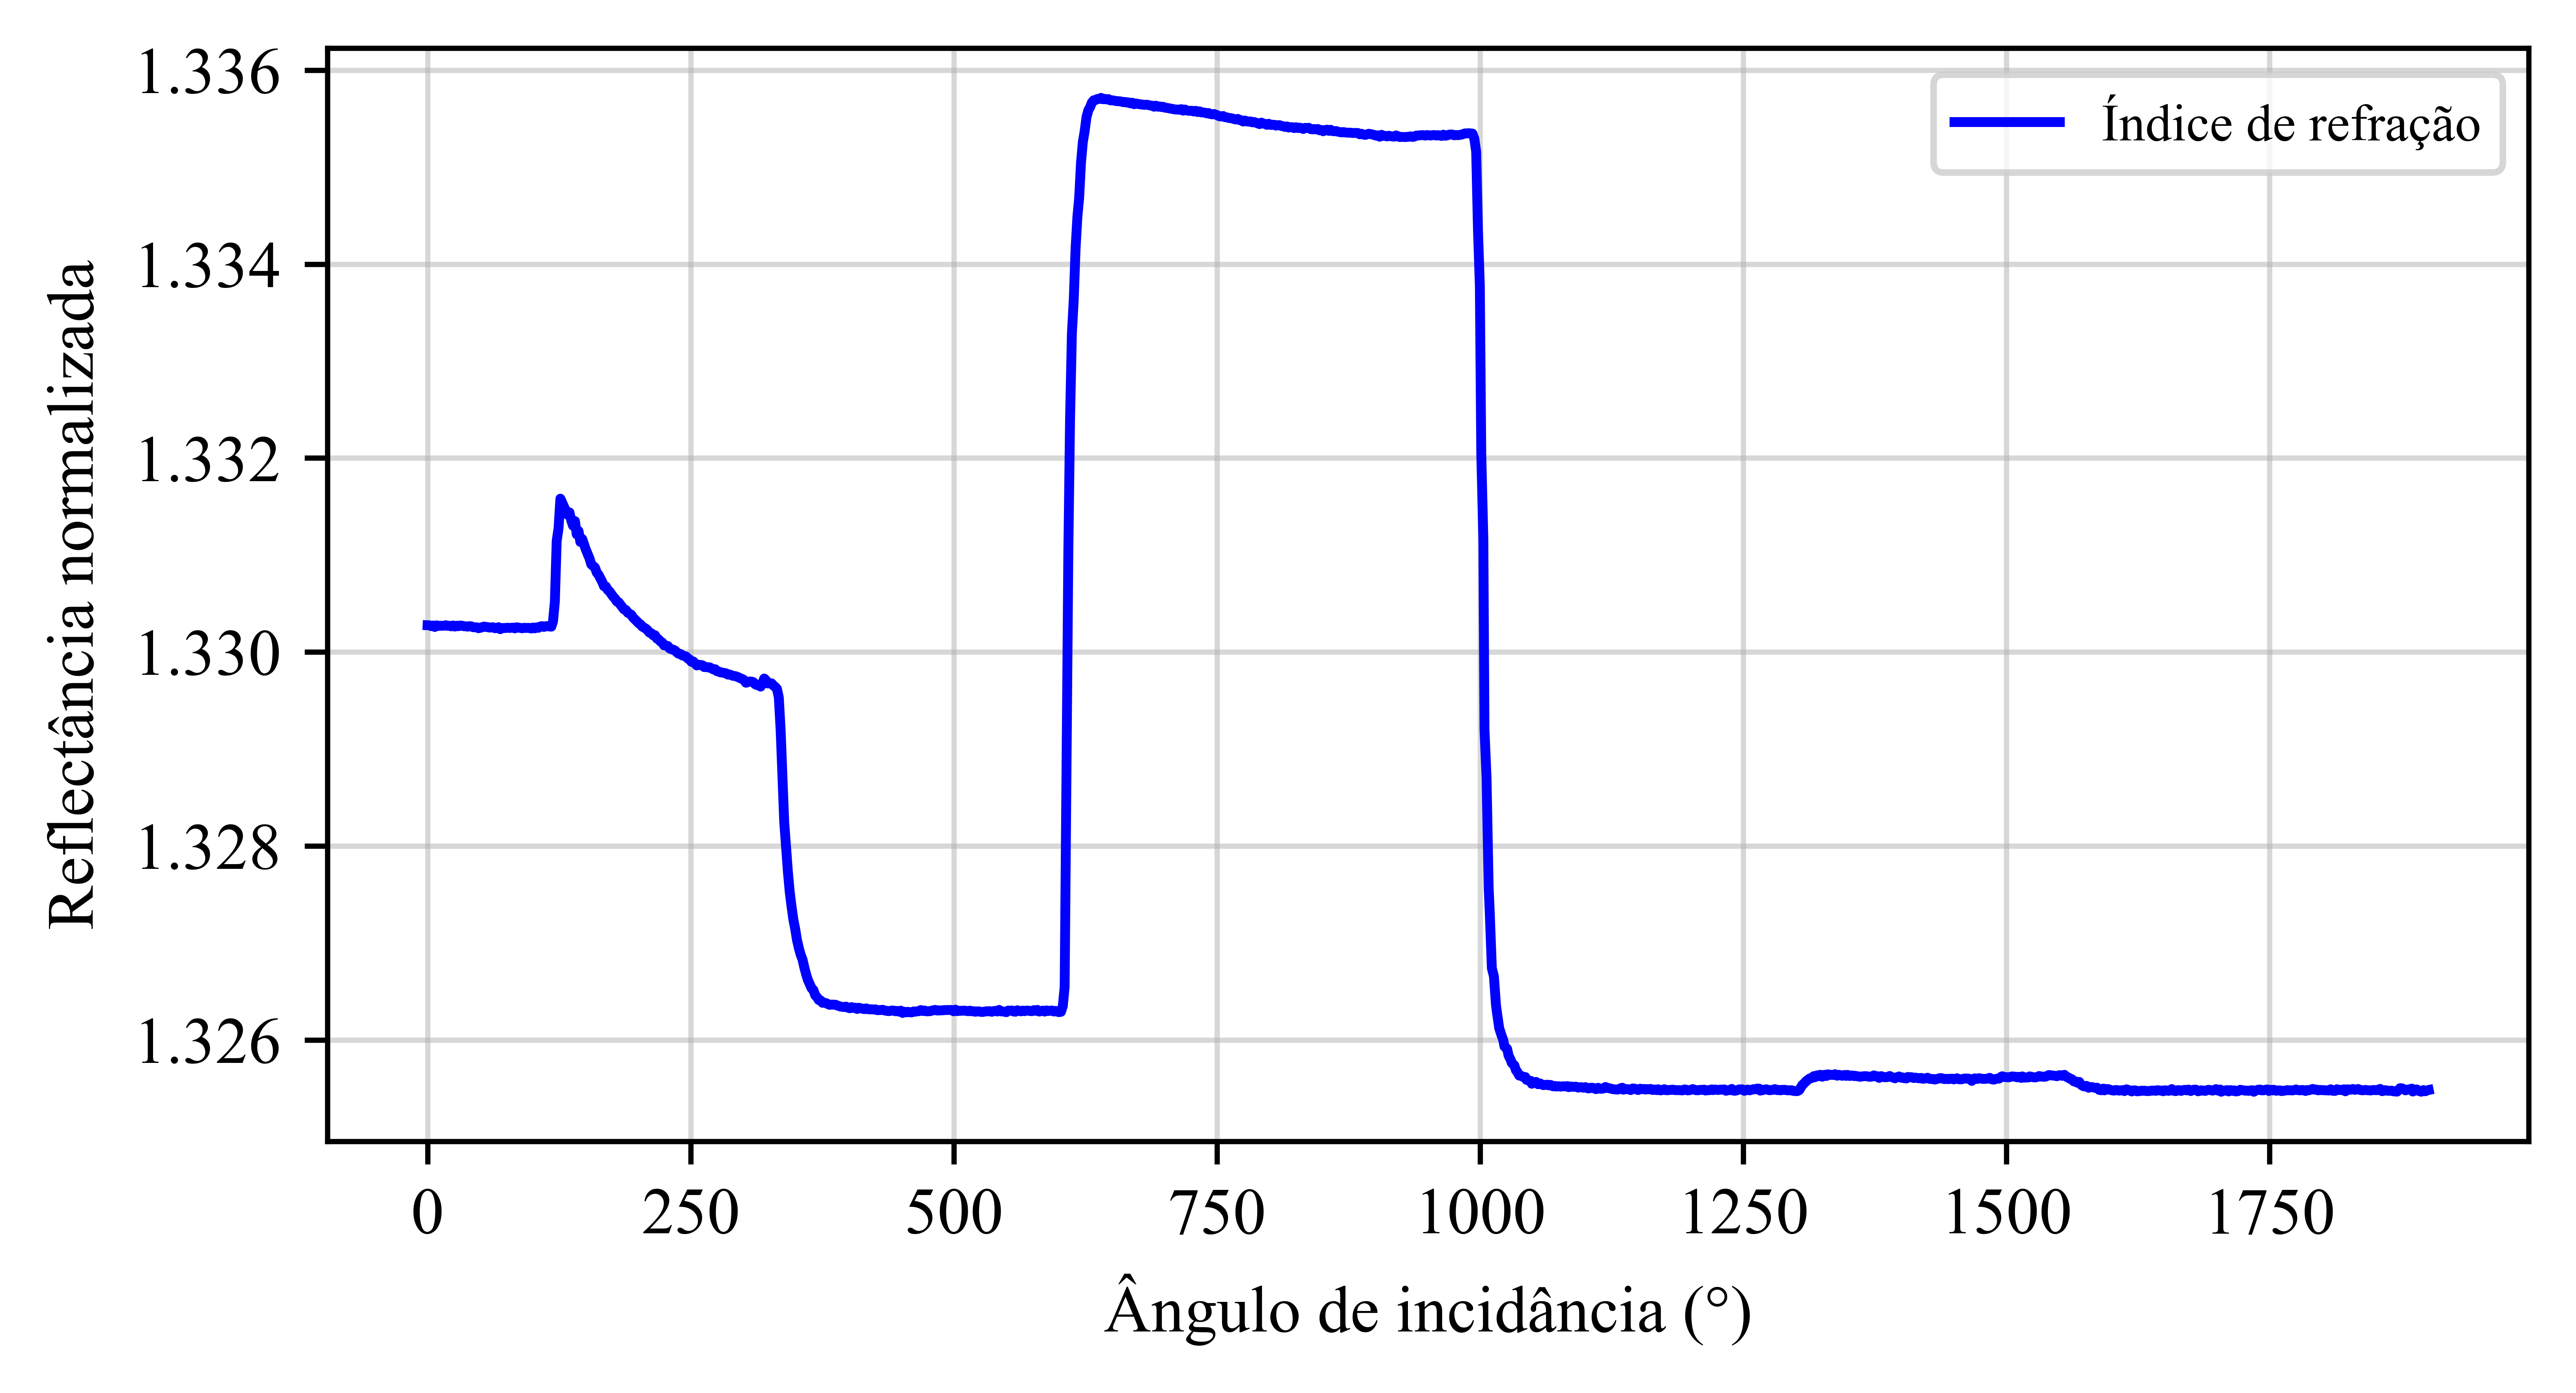

In [152]:
dados_raw = pd.read_csv("raw data.csv", encoding='latin1')

ri = dados_raw["Refractive Index"] 
t = dados_raw["Time(s)"]

t = [float(i) for i in t]

plt.subplots(dpi=1200, figsize=(6,3))
plt.plot(t,ri, "-b", label='Índice de refração')
plt.grid(True, alpha=0.5)
plt.legend(fontsize=8)
plt.xlabel("Ângulo de incidância (°)")
plt.ylabel("Reflectância normalizada")
plt.show()

## Geração das curvas que simulam os dados do sensor

É criado um arquivo *'Sensor_data.txt'* que recebe os dados das curvas geradas: Tempo(s), Lista de ângulos de incidência, Sinal bruto em *Volts* e Reflectância normalizada pela curva de referência.  

O arquivo com as curvas de referencia são lidos e, para cada ângulo de incidência, comprimento de onda e índice de refração, são calculados valores de reflectância com base nos algoritmos já mostrados acima, sendo em seguida, armazenados no arquivo criado.

In [ ]:
start_time = time.time()
arquivo = open('Sensor_data.txt','w')
arquivo.write("time(s)\tAngle\tSignal\tSPR Curve")

signal_ref_txt = pd.read_csv('Reference_data_wet.csv', encoding='latin1')

pixel_ = signal_ref_txt['Pixel #']
angle_ = signal_ref_txt['Angle']
signal_ref = signal_ref_txt['Noise_Ref']
theta_i = []
noise_term = gauss(0, 0.1)

noise_space = signal_ref_txt['Noise_space']

for i in pixel_:
    theta_i.append((3.1522 * 1E-5 * i**2) - (0.0661 * i) + 73.4533)

for i in ri:
    
    r = lambda theta, lambda_i: ref.reflectivity(3, [1, 50*1E-9, 1], [1.4826, set_index_3(lambda_i), i], theta*pi/180, lambda_i*1e-9)
    def f(w_i, theta):
        return (r(theta, w_i)*sp(w_i))

    #Integral
    integrals = [[a, quad(f,  750, 930, args=(a))[0]] for a in linspace(73.6572,65.65896, 128)]

    reflectancia = array(integrals).T[1] / quad(sp, 750, 930)[0]

    reflectancia = ((reflectancia + noise_space) * signal_ref) + noise_term

    end_time = time.time()
    interval = round((end_time - start_time), 5)
    
    arquivo.write(f"\n{interval}\t{theta_i}\t{list(reflectancia)}\t{list(reflectancia/signal_ref)}")

arquivo.close()   

A partir daqui esse arquivo criado é lido na interface e os sinais são processados.
